##### Linear regression

In [162]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD
import datetime
import matplotlib.pyplot as plt
import seaborn as sns



In [163]:
# Now read the CSV file with Pandas
columns_to_include = list(range(10))  # This creates a list of integers from 0 to 9
dataset = pd.read_csv('combined_data.csv', delimiter=';', usecols=columns_to_include)

In [164]:
dataset.describe()

Module Temperature   Irradiance  Temperature     Humidity     Pressure  \
count         8677.000000  8677.000000  8677.000000  8677.000000  8677.000000   
mean            18.956684   184.178341    16.519039    76.661288  1000.179244   
std              6.963750   276.750401     4.107779    14.171330     5.815970   
min              5.753000     0.753000     4.100000    14.000000   979.600000   
25%             13.813000     9.034000    13.500000    68.000000   996.200000   
50%             17.682000    12.884000    16.800000    79.000000   999.700000   
75%             22.627000   285.462000    19.500000    88.000000  1003.500000   
max             46.834000  1105.863000    33.600000    98.000000  1024.600000   

        Wind Speed  Wind Direction         Rain  PV yield counter  
count  8677.000000     8677.000000  8677.000000       8677.000000  
mean      3.107894      190.654604     0.070324         31.140359  
std       1.853554       99.243962     0.518546         46.648630  
min       0.000000        0.000000     0.000000          0.000000  
25%       1.800000      100.000000     0.000000          0.000000  
50%       2.800000      220.000000     0.000000          0.762000  
75%       4.200000      270.000000     0.000000         52.181000  
max      12.700000      360.000000    15.200000        166.553000

Setting up the actual model

In [165]:
X = dataset.iloc[:, 1:-1].values  # Select columns from the second to the second-to-last as features, we ignoring timestamp
y = dataset.iloc[:, -1].values   # Select the last column as the target variable

In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)  # Fitting our model to the training set

LinearRegression()

In [167]:
y_pred = model.predict(X_test)
y_pred[0:10]  # Predicted Values

array([27.25773288, 76.32594168,  3.54206996,  3.20263174, 92.78158729,
       66.28651029,  2.81736272, 51.13449079,  1.739712  , 64.96672514])

In [168]:
y_test = np.array(y_test)
y_test[0:10]  # Expected output

array([ 32.247,  80.501,   0.   ,   0.   ,  85.467, 100.324,   0.   ,
        71.355,   0.   , 100.677])

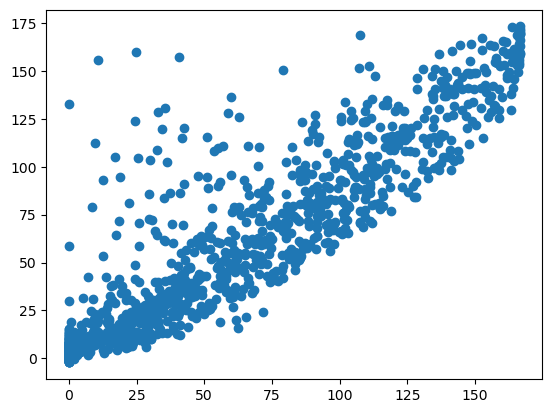

In [76]:

import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)


In [77]:
average_y_pred = np.mean(y_pred)
average_y_test = np.mean(y_test)
print("Average of Predictions (y_pred):", average_y_pred)
print("Average of Test Values (y_test):", average_y_test)


Average of Predictions (y_pred): 32.15321269757801
Average of Test Values (y_test): 32.26748248847927


In [78]:
# Calculating the performance metrics
from sklearn import metrics  
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = model.score(X_test, y_test)
mape = np.abs((average_y_test - average_y_pred) / average_y_test) * 100


print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)
print("MAPE:", mape)


MAE: 8.765353131872978
MSE: 249.86050753934967
RMSE: 15.806976546428785
R-squared: 0.8885787261126769
MAPE: 0.3541329601466514


In [79]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=2, scoring='neg_mean_absolute_error')

# Print the mean MAE across all folds
print("Mean MAE:", -scores.mean())


Mean MAE: 8.532201397598355


In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

k_values = range(2, 11) 

k_scores = {}

for k in k_values:
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=k, scoring='neg_mean_absolute_error')
    k_scores[k] = -scores.mean()  # Store the mean MAE (negated) for each k

optimal_k = min(k_scores, key=k_scores.get)

print("Mean MAE Scores for Each k:")
for k, score in k_scores.items():
    print(f"k = {k}: Mean MAE = {score}")

print("\nOptimal number of folds (k):", optimal_k)
print("Mean MAE for optimal k:", k_scores[optimal_k])


Mean MAE Scores for Each k:
k = 2: Mean MAE = 8.532201397598355
k = 3: Mean MAE = 8.563936083690992
k = 4: Mean MAE = 8.573286248727596
k = 5: Mean MAE = 8.590306262854693
k = 6: Mean MAE = 8.60125750284069
k = 7: Mean MAE = 8.609851952696085
k = 8: Mean MAE = 8.600641547676434
k = 9: Mean MAE = 8.600778924136403
k = 10: Mean MAE = 8.60225728891412

Optimal number of folds (k): 2
Mean MAE for optimal k: 8.532201397598355


In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],  # Use positive=True for non-negative constraints
    'copy_X': [True, False],
    'n_jobs': [-1]  # Use -1 to utilize all available processors
}

# Create a Linear Regression model
model = LinearRegression()

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Mean MAE with Best Hyperparameters:", -grid_search.best_score_)


Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
Mean MAE with Best Hyperparameters: 8.522156085930147


In [82]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression

# Define the parameter grid to search for other hyperparameters
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1]
}

k_values = range(2, 11)  

model = LinearRegression()


cv = KFold(n_splits=2)  


grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=cv)
grid_search.fit(X, y)

print("Best Hyperparameters and k Value:", grid_search.best_params_)
print("Mean MAE with Best Hyperparameters:", -grid_search.best_score_)


Best Hyperparameters and k Value: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
Mean MAE with Best Hyperparameters: 8.456858938302263


Equation of the line of best fit:
y = -190.83 + 0.92x1 + 0.14x2 + -0.69x3 + -0.19x4 + 0.20x5 + 0.05x6 + 0.00x7 + 0.12x8


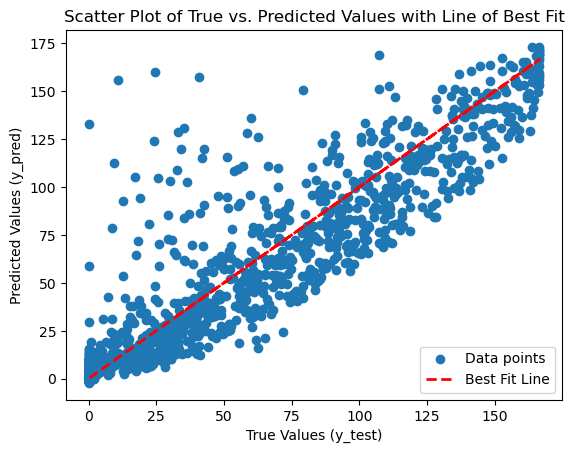

In [84]:
# Importing LinearRegression Class from sklearn
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
model = LinearRegression()

# Fitting our model to the training set
model.fit(X_train, y_train)

# Get coefficients and intercept after fitting the model
coefficients = model.coef_
intercept = model.intercept_

# Print the equation of the line of best fit
equation = "y = {:.2f}".format(intercept)
for i in range(len(coefficients)):
    equation += " + {:.2f}x{}".format(coefficients[i], i+1)
print("Equation of the line of best fit:")
print(equation)

# Now, plot the scatter plot with the line of best fit
plt.scatter(y_test, y_pred, label='Data points')
plt.plot(y_test, y_test, color='red', linestyle='--', linewidth=2, label='Best Fit Line')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Scatter Plot of True vs. Predicted Values with Line of Best Fit')
plt.legend()
plt.show()


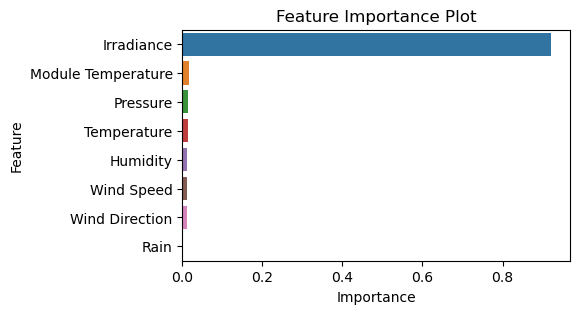

In [74]:
from sklearn.ensemble import RandomForestRegressor

# Using RandomForestRegressor to calculate feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

feature_df = pd.DataFrame({'Feature': dataset.columns[1:-1], 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()


# Testing and results

In [85]:
# Convert 'Timestamp' column to datetime
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])

october_data = dataset[(dataset['Timestamp'].dt.year == 2022) & (dataset['Timestamp'].dt.month == 10)]


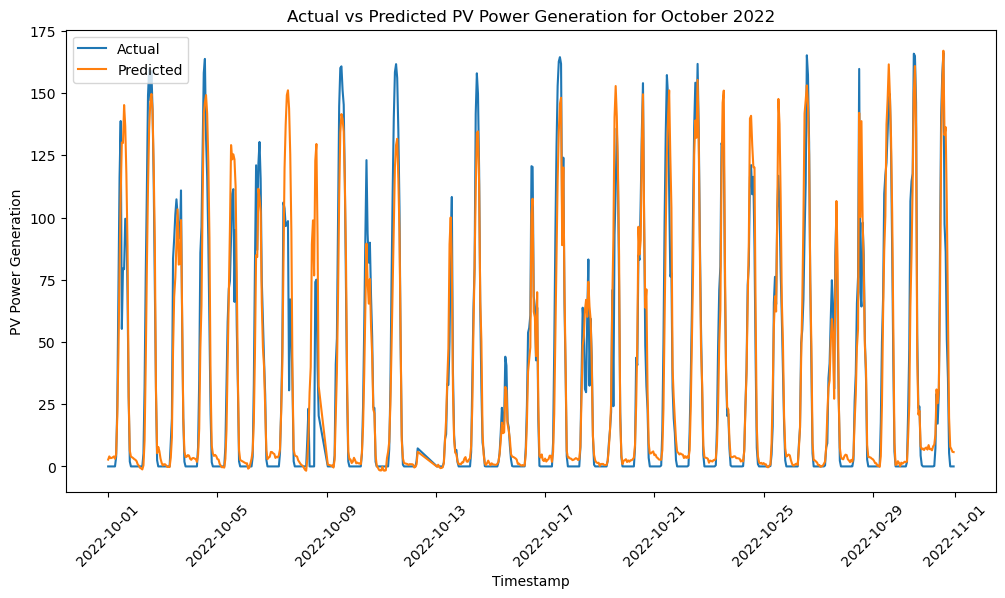

MAE for October 2022: 9.446970005650227
MSE for October 2022: 280.64047679752673
RMSE for October 2022: 16.752327503888132
R-squared for October 2022: 0.8806605127434761


In [91]:
# Separate features and target variable
X_october = october_data.iloc[:, 1:-1].values  # Features
y_october_actual = october_data.iloc[:, -1].values  # Actual PV power generation

y_october_pred = model.predict(X_october)

plt.figure(figsize=(12, 6))

plt.plot(october_data['Timestamp'], y_october_actual, label='Actual', )

plt.plot(october_data['Timestamp'], y_october_pred, label='Predicted', )

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for October 2022')
plt.legend()
plt.xticks(rotation=45)

# Display he plot
plt.show()


from sklearn import metrics

mae_october = metrics.mean_absolute_error(y_october_actual, y_october_pred)
mse_october = metrics.mean_squared_error(y_october_actual, y_october_pred)
rmse_october = np.sqrt(mse_october)
r2_october = metrics.r2_score(y_october_actual, y_october_pred)

print("MAE for October 2022:", mae_october)
print("MSE for October 2022:", mse_october)
print("RMSE for October 2022:", rmse_october)
print("R-squared for October 2022:", r2_october)


In [92]:
# Filter data for October 2022
october_data = dataset[(dataset['Timestamp'].dt.year == 2022) & (dataset['Timestamp'].dt.month == 10)]

# Separate features and target variable for October 2022
X_october = october_data.iloc[:, 1:-1].values
y_october_actual = october_data.iloc[:, -1].values

y_october_pred = model.predict(X_october)

mae_october = metrics.mean_absolute_error(y_october_actual, y_october_pred)
mse_october = metrics.mean_squared_error(y_october_actual, y_october_pred)
rmse_october = np.sqrt(mse_october)
r2_october = metrics.r2_score(y_october_actual, y_october_pred)

average_y_october_pred = np.mean(y_october_pred)
average_y_october_actual = np.mean(y_october_actual)
mape_october = np.abs((average_y_october_actual - average_y_october_pred) / average_y_october_actual) * 100

print("Metrics for October 2022:")
print("Mean Absolute Error (MAE):", mae_october)
print("Mean Squared Error (MSE):", mse_october)
print("Root Mean Squared Error (RMSE):", rmse_october)
print("R-squared (R2):", r2_october)
print("Mean Absolute Percentage Error (MAPE):", mape_october)


Metrics for October 2022:
Mean Absolute Error (MAE): 9.446970005650227
Mean Squared Error (MSE): 280.64047679752673
Root Mean Squared Error (RMSE): 16.752327503888132
R-squared (R2): 0.8806605127434761
Mean Absolute Percentage Error (MAPE): 4.3769333966822765


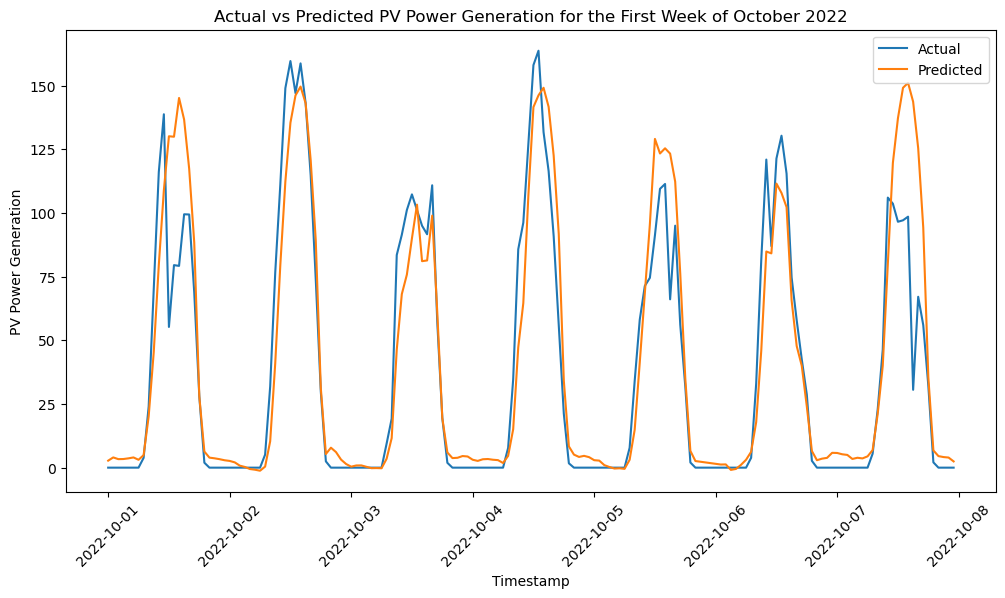

MAE for the first week of October 2022: 12.296403378096914
MSE for the first week of October 2022: 430.76999392212474
RMSE for the first week of October 2022: 20.75499925131593
R-squared for the first week of October 2022: 0.8226118735870995


In [93]:
# Filter data for the first week of October 2022
october_first_week_data = dataset[(dataset['Timestamp'].dt.year == 2022) & 
                                   (dataset['Timestamp'].dt.month == 10) & 
                                   (dataset['Timestamp'].dt.day <= 7)]
X_october_first_week = october_first_week_data.iloc[:, 1:-1].values  # Features
y_october_first_week_actual = october_first_week_data.iloc[:, -1].values  # Actual PV power generation
y_october_first_week_pred = model.predict(X_october_first_week)

plt.figure(figsize=(12, 6))
plt.plot(october_first_week_data['Timestamp'], y_october_first_week_actual, label='Actual',)
plt.plot(october_first_week_data['Timestamp'], y_october_first_week_pred, label='Predicted',)
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of October 2022')
plt.legend()
plt.xticks(rotation=45)
plt.show()

mae_october_first_week = metrics.mean_absolute_error(y_october_first_week_actual, y_october_first_week_pred)
mse_october_first_week = metrics.mean_squared_error(y_october_first_week_actual, y_october_first_week_pred)
rmse_october_first_week = np.sqrt(mse_october_first_week)
r2_october_first_week = metrics.r2_score(y_october_first_week_actual, y_october_first_week_pred)

print("MAE for the first week of October 2022:", mae_october_first_week)
print("MSE for the first week of October 2022:", mse_october_first_week)
print("RMSE for the first week of October 2022:", rmse_october_first_week)
print("R-squared for the first week of October 2022:", r2_october_first_week)





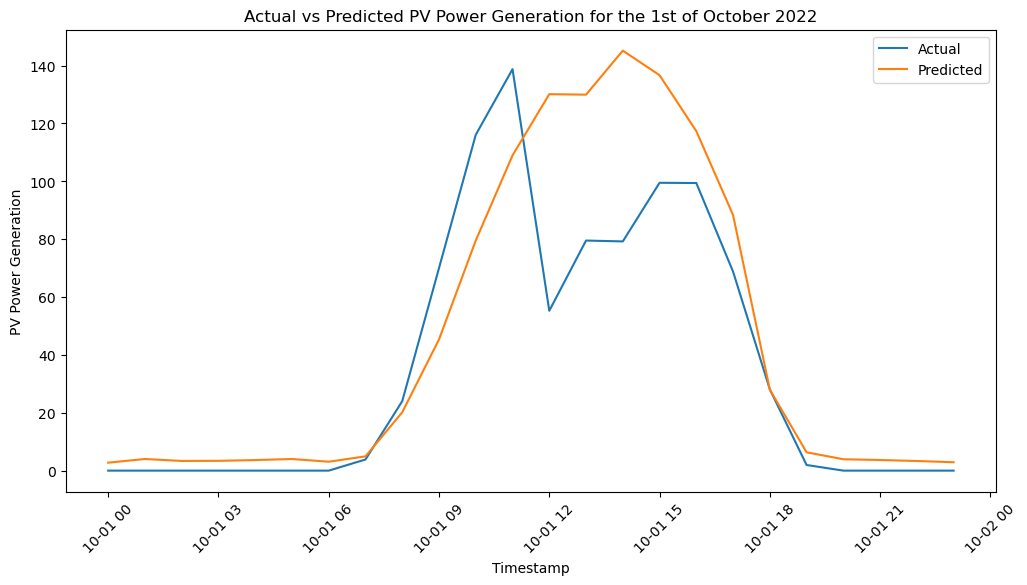

MAE for the 1st of October 2022: 16.852392520610277
MSE for the 1st of October 2022: 732.7804898507256
RMSE for the 1st of October 2022: 27.06991854163447
R-squared for the 1st of October 2022: 0.6339926428423391
Mean Absolute Percentage Error (MAPE) for October 1st, 2022: 24.81365513144468


In [94]:
# Convert 'Timestamp' column to datetime
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])

october_1st_data = dataset[(dataset['Timestamp'].dt.year == 2022) & 
                           (dataset['Timestamp'].dt.month == 10) & 
                           (dataset['Timestamp'].dt.day == 1)]

X_october_1st = october_1st_data.iloc[:, 1:-1].values  # Features
y_october_1st_actual = october_1st_data.iloc[:, -1].values  # Actual PV power generation

y_october_1st_pred = model.predict(X_october_1st)

plt.figure(figsize=(12, 6))

plt.plot(october_1st_data['Timestamp'], y_october_1st_actual, label='Actual')

plt.plot(october_1st_data['Timestamp'], y_october_1st_pred, label='Predicted')

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the 1st of October 2022')

plt.legend()
plt.xticks(rotation=45)

plt.show()

from sklearn import metrics
mae_october_1st = metrics.mean_absolute_error(y_october_1st_actual, y_october_1st_pred)
mse_october_1st = metrics.mean_squared_error(y_october_1st_actual, y_october_1st_pred)
rmse_october_1st = np.sqrt(mse_october_1st)
r2_october_1st = metrics.r2_score(y_october_1st_actual, y_october_1st_pred)

average_y_october_1st_pred = np.mean(y_october_1st_pred)
average_y_october_1st_actual = np.mean(y_october_1st_actual)
mape_october_1st = np.abs((average_y_october_1st_actual - average_y_october_1st_pred) / average_y_october_1st_actual) * 100

print("MAE for the 1st of October 2022:", mae_october_1st)
print("MSE for the 1st of October 2022:", mse_october_1st)
print("RMSE for the 1st of October 2022:", rmse_october_1st)
print("R-squared for the 1st of October 2022:", r2_october_1st)
print("Mean Absolute Percentage Error (MAPE) for October 1st, 2022:", mape_october_1st)


DECEMBER 2022

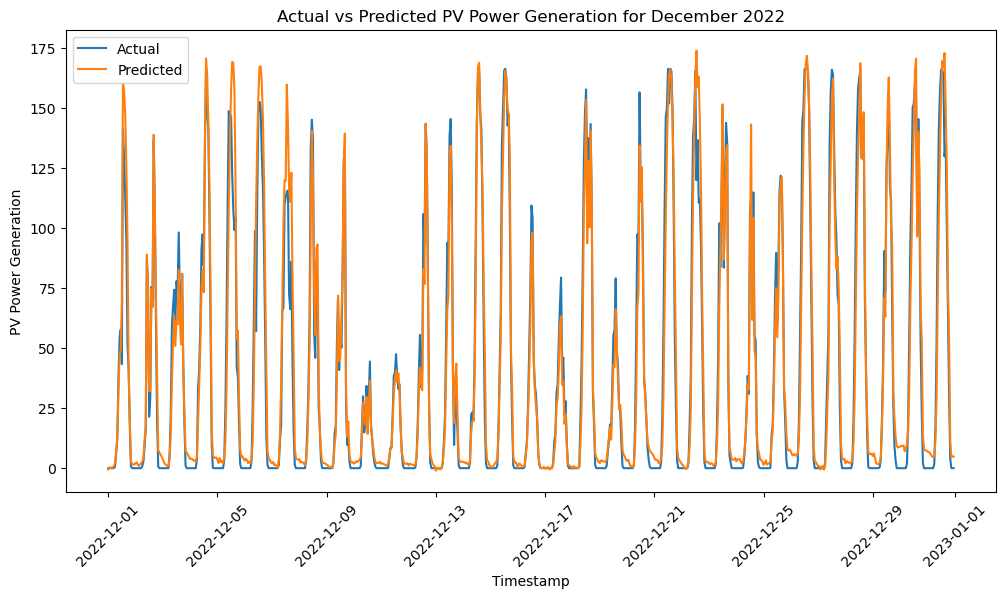

MAE for December 2022: 7.845784926092248
MSE for December 2022: 157.042679687807
RMSE for December 2022: 12.53166707536579
R-squared for December 2022: 0.9428014297521868
MAPE for December 2022: 2.224406055094243


In [95]:
# Filter data for December 2022
december_data = dataset[(dataset['Timestamp'].dt.year == 2022) & (dataset['Timestamp'].dt.month == 12)]

X_december = december_data.iloc[:, 1:-1].values  # Features
y_december_actual = december_data.iloc[:, -1].values  # Actual PV power generation

y_december_pred = model.predict(X_december)

plt.figure(figsize=(12, 6))

plt.plot(december_data['Timestamp'], y_december_actual, label='Actual')

plt.plot(december_data['Timestamp'], y_december_pred, label='Predicted')

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for December 2022')

plt.legend()
plt.xticks(rotation=45)

plt.show()


mae_december = metrics.mean_absolute_error(y_december_actual, y_december_pred)
mse_december = metrics.mean_squared_error(y_december_actual, y_december_pred)
rmse_december = np.sqrt(mse_december)
r2_december = metrics.r2_score(y_december_actual, y_december_pred)


average_y_december_pred = np.mean(y_december_pred)
average_y_december_actual = np.mean(y_december_actual)

mape_december = np.abs((average_y_december_actual - average_y_december_pred) / average_y_december_actual) * 100

print("MAE for December 2022:", mae_december)
print("MSE for December 2022:", mse_december)
print("RMSE for December 2022:", rmse_december)
print("R-squared for December 2022:", r2_december)
print("MAPE for December 2022:", mape_december)


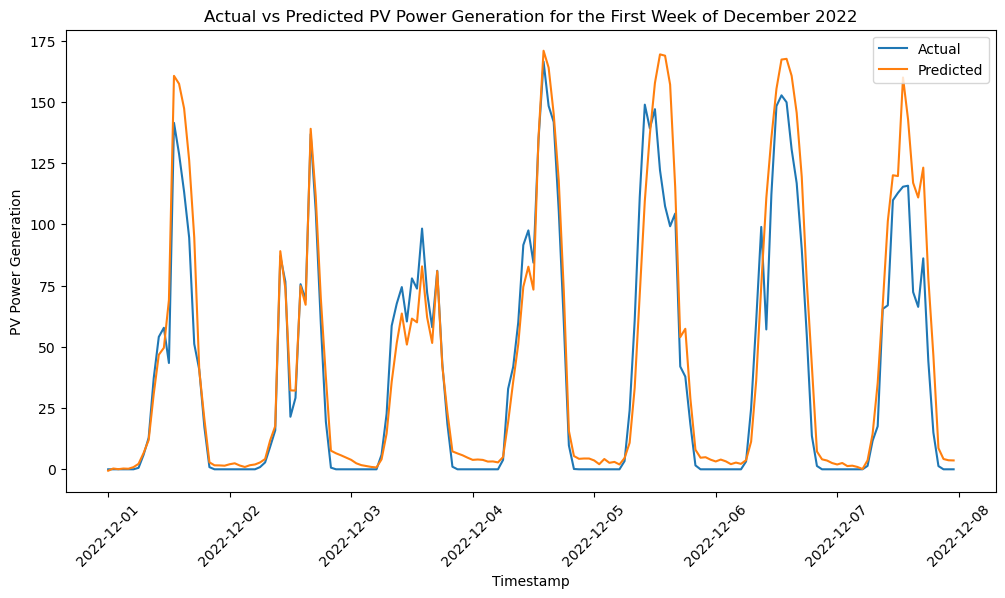

Metrics for the first week of December 2022:
MAE: 10.52190599104834
MSE: 276.53772933976245
RMSE: 16.62942360215057
R-squared: 0.8833542907954528
MAPE: 13.748198209284778


In [96]:

december_first_week_data = dataset[(dataset['Timestamp'].dt.year == 2022) & 
                                    (dataset['Timestamp'].dt.month == 12) & 
                                    (dataset['Timestamp'].dt.day <= 7)]


X_december_first_week = december_first_week_data.iloc[:, 1:-1].values
y_december_first_week_actual = december_first_week_data.iloc[:, -1].values


y_december_first_week_pred = model.predict(X_december_first_week)


plt.figure(figsize=(12, 6))
plt.plot(december_first_week_data['Timestamp'], y_december_first_week_actual, label='Actual')
plt.plot(december_first_week_data['Timestamp'], y_december_first_week_pred, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of December 2022')
plt.legend()
plt.xticks(rotation=45)
plt.show()

mae_december_first_week = metrics.mean_absolute_error(y_december_first_week_actual, y_december_first_week_pred)
mse_december_first_week = metrics.mean_squared_error(y_december_first_week_actual, y_december_first_week_pred)
rmse_december_first_week = np.sqrt(mse_december_first_week)
r2_december_first_week = metrics.r2_score(y_december_first_week_actual, y_december_first_week_pred)

average_y_december_first_week_pred = np.mean(y_december_first_week_pred)
average_y_december_first_week_actual = np.mean(y_december_first_week_actual)
mape_december_first_week = np.abs((average_y_december_first_week_actual - average_y_december_first_week_pred) / average_y_december_first_week_actual) * 100

print("Metrics for the first week of December 2022:")
print("MAE:", mae_december_first_week)
print("MSE:", mse_december_first_week)
print("RMSE:", rmse_december_first_week)
print("R-squared:", r2_december_first_week)
print("MAPE:", mape_december_first_week)

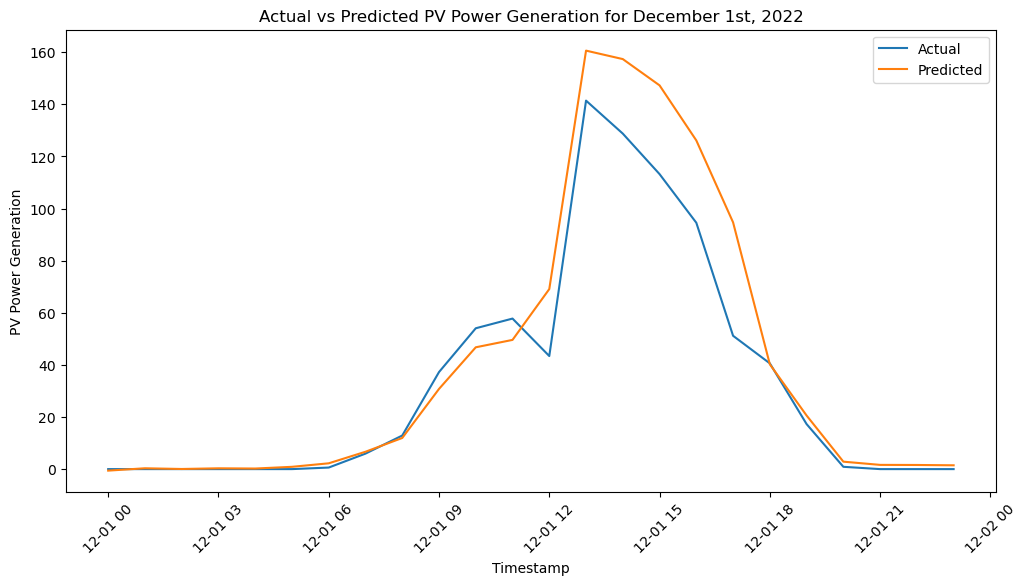

Metrics for December 1st, 2022:
MAE: 9.190315493678211
MSE: 253.70517630376094
RMSE: 15.928125322955019
R-squared: 0.8675547592969588
MAPE: 21.619681036053777


In [97]:

december_1st_data = dataset[(dataset['Timestamp'].dt.year == 2022) & 
                             (dataset['Timestamp'].dt.month == 12) & 
                             (dataset['Timestamp'].dt.day == 1)]

X_december_1st = december_1st_data.iloc[:, 1:-1].values
y_december_1st_actual = december_1st_data.iloc[:, -1].values

y_december_1st_pred = model.predict(X_december_1st)


plt.figure(figsize=(12, 6))
plt.plot(december_1st_data['Timestamp'], y_december_1st_actual, label='Actual')
plt.plot(december_1st_data['Timestamp'], y_december_1st_pred, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for December 1st, 2022')
plt.legend()
plt.xticks(rotation=45)
plt.show()

mae_december_1st = metrics.mean_absolute_error(y_december_1st_actual, y_december_1st_pred)
mse_december_1st = metrics.mean_squared_error(y_december_1st_actual, y_december_1st_pred)
rmse_december_1st = np.sqrt(mse_december_1st)
r2_december_1st = metrics.r2_score(y_december_1st_actual, y_december_1st_pred)

average_y_december_1st_pred = np.mean(y_december_1st_pred)
average_y_december_1st_actual = np.mean(y_december_1st_actual)
mape_december_1st = np.abs((average_y_december_1st_actual - average_y_december_1st_pred) / average_y_december_1st_actual) * 100

print("Metrics for December 1st, 2022:")
print("MAE:", mae_december_1st)
print("MSE:", mse_december_1st)
print("RMSE:", rmse_december_1st)
print("R-squared:", r2_december_1st)
print("MAPE:", mape_december_1st)


MARCH 2023

In [98]:
# Filter data for March 2023
march_data = dataset[(dataset['Timestamp'].dt.year == 2023) & (dataset['Timestamp'].dt.month == 3)]

X_march = march_data.iloc[:, 1:-1].values
y_march_actual = march_data.iloc[:, -1].values

y_march_pred = model.predict(X_march)

mae_march = metrics.mean_absolute_error(y_march_actual, y_march_pred)
mse_march = metrics.mean_squared_error(y_march_actual, y_march_pred)
rmse_march = np.sqrt(mse_march)
r2_march = metrics.r2_score(y_march_actual, y_march_pred)


average_y_march_pred = np.mean(y_march_pred)
average_y_march_actual = np.mean(y_march_actual)
mape_march = np.abs((average_y_march_actual - average_y_march_pred) / average_y_march_actual) * 100


print("Metrics for March 2023:")
print("Mean Absolute Error (MAE):", mae_march)
print("Mean Squared Error (MSE):", mse_march)
print("Root Mean Squared Error (RMSE):", rmse_march)
print("R-squared (R2):", r2_march)
print("Mean Absolute Percentage Error (MAPE):", mape_march)


Metrics for March 2023:
Mean Absolute Error (MAE): 9.898392340367016
Mean Squared Error (MSE): 350.76540674885916
Root Mean Squared Error (RMSE): 18.728732118028148
R-squared (R2): 0.8574344434915151
Mean Absolute Percentage Error (MAPE): 1.4758685694112075


In [99]:
# Filter data for the first week of March 2023
march_first_week_data = dataset[(dataset['Timestamp'].dt.year == 2023) & 
                                 (dataset['Timestamp'].dt.month == 3) & 
                                 (dataset['Timestamp'].dt.day <= 7)]

X_march_first_week = march_first_week_data.iloc[:, 1:-1].values
y_march_first_week_actual = march_first_week_data.iloc[:, -1].values

y_march_first_week_pred = model.predict(X_march_first_week)

mae_march_first_week = metrics.mean_absolute_error(y_march_first_week_actual, y_march_first_week_pred)
mse_march_first_week = metrics.mean_squared_error(y_march_first_week_actual, y_march_first_week_pred)
rmse_march_first_week = np.sqrt(mse_march_first_week)
r2_march_first_week = metrics.r2_score(y_march_first_week_actual, y_march_first_week_pred)

average_y_march_first_week_pred = np.mean(y_march_first_week_pred)
average_y_march_first_week_actual = np.mean(y_march_first_week_actual)
mape_march_first_week = np.abs((average_y_march_first_week_actual - average_y_march_first_week_pred) / average_y_march_first_week_actual) * 100

# Print metrics for the first week of March 2023
print("Metrics for the first week of March 2023:")
print("Mean Absolute Error (MAE):", mae_march_first_week)
print("Mean Squared Error (MSE):", mse_march_first_week)
print("Root Mean Squared Error (RMSE):", rmse_march_first_week)
print("R-squared (R2):", r2_march_first_week)
print("Mean Absolute Percentage Error (MAPE):", mape_march_first_week)


Metrics for the first week of March 2023:
Mean Absolute Error (MAE): 8.37466905359357
Mean Squared Error (MSE): 358.06521996066004
Root Mean Squared Error (RMSE): 18.922611340950276
R-squared (R2): 0.8360127161759365
Mean Absolute Percentage Error (MAPE): 0.07151350373307126


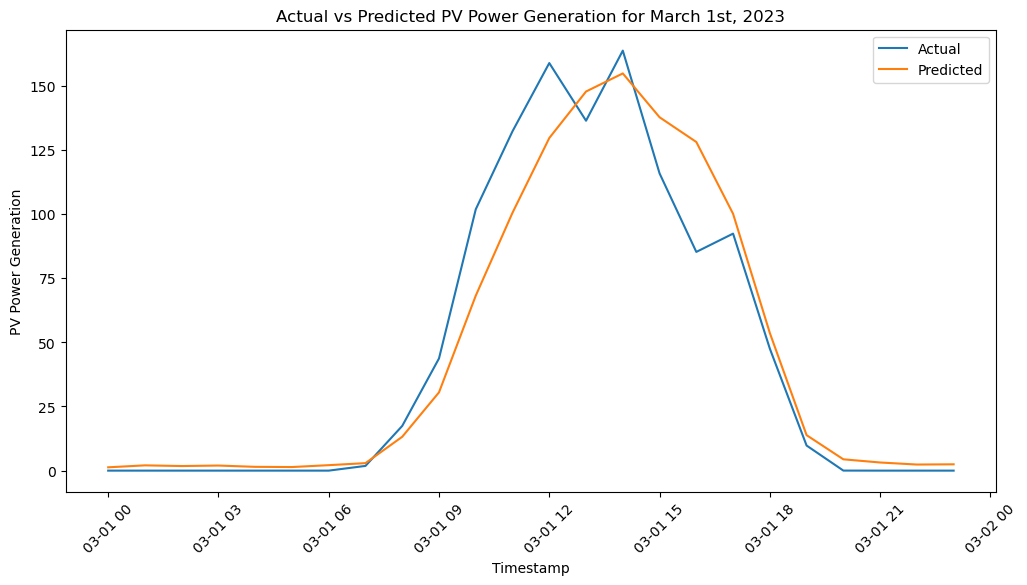

Metrics for March 1st, 2023:
MAE: 10.02032410617834
MSE: 245.1866273113118
RMSE: 15.658436298408338
R-squared: 0.9275355892603683
MAPE: 0.12732714954531765


In [100]:
# Filter data for March 1st, 2023
march_1st_data = dataset[(dataset['Timestamp'].dt.year == 2023) & 
                          (dataset['Timestamp'].dt.month == 3) & 
                          (dataset['Timestamp'].dt.day == 1)]

X_march_1st = march_1st_data.iloc[:, 1:-1].values
y_march_1st_actual = march_1st_data.iloc[:, -1].values

y_march_1st_pred = model.predict(X_march_1st)

plt.figure(figsize=(12, 6))
plt.plot(march_1st_data['Timestamp'], y_march_1st_actual, label='Actual')
plt.plot(march_1st_data['Timestamp'], y_march_1st_pred, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for March 1st, 2023')
plt.legend()
plt.xticks(rotation=45)
plt.show()

mae_march_1st = metrics.mean_absolute_error(y_march_1st_actual, y_march_1st_pred)
mse_march_1st = metrics.mean_squared_error(y_march_1st_actual, y_march_1st_pred)
rmse_march_1st = np.sqrt(mse_march_1st)
r2_march_1st = metrics.r2_score(y_march_1st_actual, y_march_1st_pred)

average_y_march_1st_pred = np.mean(y_march_1st_pred)
average_y_march_1st_actual = np.mean(y_march_1st_actual)
mape_march_1st = np.abs((average_y_march_1st_actual - average_y_march_1st_pred) / average_y_march_1st_actual) * 100


print("Metrics for March 1st, 2023:")
print("MAE:", mae_march_1st)
print("MSE:", mse_march_1st)
print("RMSE:", rmse_march_1st)
print("R-squared:", r2_march_1st)
print("MAPE:", mape_march_1st)


# Optimisation

In [101]:
from sklearn.feature_selection import SelectKBest, f_regression

# Select top k features based on F-statistic
k = 8  # You can adjust the number of features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Fit the model with selected features
model.fit(X_train_selected, y_train)
# Predict using the model with selected features
y_pred_selected = model.predict(X_test_selected)


In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
# Define a range of k values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8,]


cv_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    scores = cross_val_score(model, X_train_selected, y_train, cv=2)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

# Find the optimal k value with the highest cross-validation score
optimal_k = k_values[cv_scores.index(max(cv_scores))]
print("Optimal number of features:", optimal_k)


Optimal number of features: 8


In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Define a range of k values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8]


param_grid = {'k': k_values}
model = LinearRegression()

# Custom scorer function for cross-validation
def custom_scorer(estimator, X, y):
    selector = SelectKBest(score_func=f_regression, k=estimator.k)
    X_selected = selector.fit_transform(X, y)
    scores = cross_val_score(model, X_selected, y, cv=2)  # 2-fold cross-validation
    return np.mean(scores)

grid_search = GridSearchCV(estimator=SelectKBest(score_func=f_regression),
                           param_grid=param_grid,
                           scoring=custom_scorer,
                           cv=2)  # 2-fold cross-validation within GridSearchCV


grid_search.fit(X_train, y_train)


print("Optimal number of features (k):", grid_search.best_params_['k'])
print("Mean cross-validated score with optimal k:", grid_search.best_score_)


Optimal number of features (k): 8
Mean cross-validated score with optimal k: 0.8941809597595572


In [104]:
# Plotting for Feature Selection
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_selected)
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred_selected)')
plt.title('Actual vs Predicted Values after Feature Selection')
plt.show()

mae_selected = metrics.mean_absolute_error(y_test, y_pred_selected)
mse_selected = metrics.mean_squared_error(y_test, y_pred_selected)
rmse_selected = np.sqrt(mse_selected)
r2_selected = metrics.r2_score(y_test, y_pred_selected)

average_y_pred_selected = np.mean(y_pred_selected)
average_y_test_selected = np.mean(y_test)
mape_selected = np.abs((average_y_test_selected - average_y_pred_selected) / average_y_test_selected) * 100


print("Metrics after Feature Selection:")
print("Mean Absolute Error (MAE):", mae_selected)
print("Mean Squared Error (MSE):", mse_selected)
print("Root Mean Squared Error (RMSE):", rmse_selected)
print("R-squared (R2):", r2_selected)
print("Mean Absolute Percentage Error (MAPE):", mape_selected)


Metrics after Feature Selection:
Mean Absolute Error (MAE): 8.76535313187271
Mean Squared Error (MSE): 249.86050753934987
Root Mean Squared Error (RMSE): 15.80697654642879
R-squared (R2): 0.8885787261126767
Mean Absolute Percentage Error (MAPE): 0.3541329601497343


Optimal number of features: 2
Mean Absolute Error (MAE) after Feature Selection: 9.637197965563269
Mean Squared Error (MSE) after Feature Selection: 272.75052542799534
Root Mean Squared Error (RMSE) after Feature Selection: 16.51516047236585
R-squared (R2) after Feature Selection: 0.8840156337212606
Mean Absolute Percentage Error (MAPE) after Feature Selection: 2.0272847920913072e-14


Metrics for October 2022 with Feature Selection:
MAE: 9.637197965563269
MSE: 272.75052542799534
RMSE: 16.51516047236585
R-squared: 0.8840156337212606
MAPE: 2.0272847920913072e-14


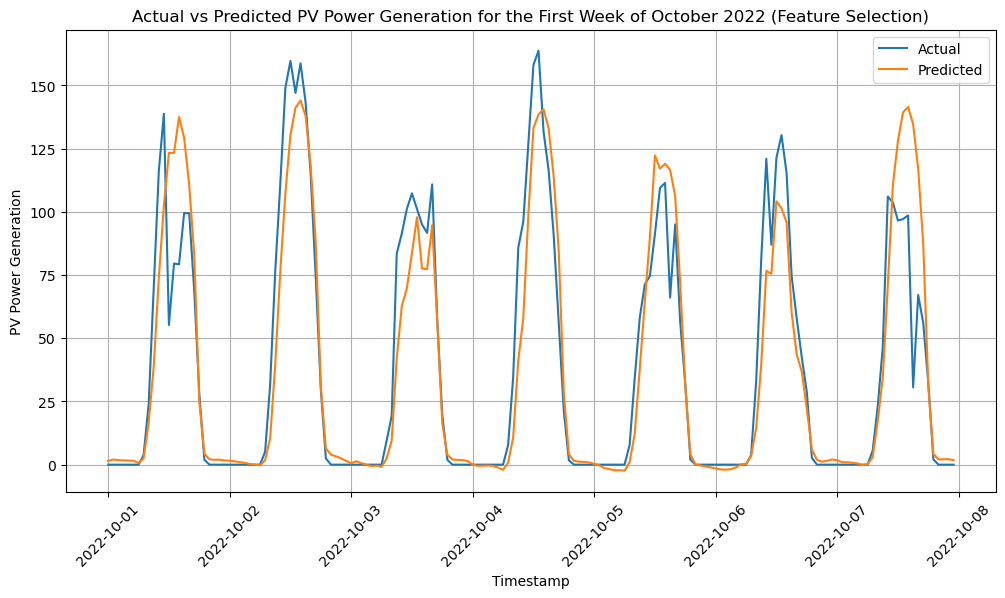

MAE for the First Week of October 2022 with Feature Selection: 11.759858631710646
MSE for the First Week of October 2022 with Feature Selection: 404.51754109836463
RMSE for the First Week of October 2022 with Feature Selection: 20.112621437753077
R-squared for the First Week of October 2022 with Feature Selection: 0.8334224534460851
Mean Absolute Percentage Error (MAPE) for the First Week of October 2022 with Feature Selection: 3.0964311584080724


MAE for 1st October 2022 with Feature Selection: 15.358090178838525
MSE for 1st October 2022 with Feature Selection: 640.5864418659268
RMSE for 1st October 2022 with Feature Selection: 25.309809202479713
R-squared for 1st October 2022 with Feature Selection: 0.6800414941913382
Mean Absolute Percentage Error (MAPE) for 1st October 2022 with Feature Selection: 14.39147233940079


In [106]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score

# Filter data for October 2022
october_2022_data = dataset[
    (dataset['Timestamp'].dt.year == 2022) &
    (dataset['Timestamp'].dt.month == 10)
]


X_october_2022 = october_2022_data.iloc[:, 1:-1].values
y_october_2022_actual = october_2022_data.iloc[:, -1].values


k_values = [1, 2, 3, 4, 5, 6, 7, 8]  # You can adjust the range of k values
cv_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X_october_2022, y_october_2022_actual)
    scores = cross_val_score(model, X_selected, y_october_2022_actual, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

optimal_k = k_values[cv_scores.index(max(cv_scores))]

selector = SelectKBest(score_func=f_regression, k=optimal_k)
X_october_2022_selected = selector.fit_transform(X_october_2022, y_october_2022_actual)

model.fit(X_october_2022_selected, y_october_2022_actual)

y_october_2022_pred_selected = model.predict(X_october_2022_selected)

mae_october_2022_selected = metrics.mean_absolute_error(y_october_2022_actual, y_october_2022_pred_selected)
mse_october_2022_selected = metrics.mean_squared_error(y_october_2022_actual, y_october_2022_pred_selected)
rmse_october_2022_selected = np.sqrt(mse_october_2022_selected)
r2_october_2022_selected = metrics.r2_score(y_october_2022_actual, y_october_2022_pred_selected)

average_y_october_2022_pred_selected = np.mean(y_october_2022_pred_selected)
average_y_october_2022_actual = np.mean(y_october_2022_actual)
mape_october_2022_selected = np.abs((average_y_october_2022_actual - average_y_october_2022_pred_selected) / average_y_october_2022_actual) * 100

print("Optimal number of features:", optimal_k)
print("Mean Absolute Error (MAE) after Feature Selection:", mae_october_2022_selected)
print("Mean Squared Error (MSE) after Feature Selection:", mse_october_2022_selected)
print("Root Mean Squared Error (RMSE) after Feature Selection:", rmse_october_2022_selected)
print("R-squared (R2) after Feature Selection:", r2_october_2022_selected)
print("Mean Absolute Percentage Error (MAPE) after Feature Selection:", mape_october_2022_selected)

plt.figure(figsize=(12, 6))
plt.scatter(y_october_2022_actual, y_october_2022_pred_selected)
plt.xlabel('True Values (y_october_2022_actual)')
plt.ylabel('Predicted Values (y_october_2022_pred_selected)')
plt.title('Actual vs Predicted Values after Feature Selection for October 2022')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(october_2022_data['Timestamp'], y_october_2022_actual, label='Actual')
plt.plot(october_2022_data['Timestamp'], y_october_2022_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for October 2022 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for October 2022 with Feature Selection:")
print("MAE:", mae_october_2022_selected)
print("MSE:", mse_october_2022_selected)
print("RMSE:", rmse_october_2022_selected)
print("R-squared:", r2_october_2022_selected)
print("MAPE:", mape_october_2022_selected)

first_week_october_2022_data = dataset[
    (dataset['Timestamp'].dt.year == 2022) &
    (dataset['Timestamp'].dt.month == 10) &
    (dataset['Timestamp'].dt.day <= 7)
]

X_first_week_october_2022 = first_week_october_2022_data.iloc[:, 1:-1].values
y_first_week_october_2022_actual = first_week_october_2022_data.iloc[:, -1].values

X_first_week_october_2022_selected = selector.transform(X_first_week_october_2022)

y_first_week_october_2022_pred_selected = model.predict(X_first_week_october_2022_selected)

mae_first_week_october_2022_selected = metrics.mean_absolute_error(y_first_week_october_2022_actual, y_first_week_october_2022_pred_selected)
mse_first_week_october_2022_selected = metrics.mean_squared_error(y_first_week_october_2022_actual, y_first_week_october_2022_pred_selected)
rmse_first_week_october_2022_selected = np.sqrt(mse_first_week_october_2022_selected)
r2_first_week_october_2022_selected = metrics.r2_score(y_first_week_october_2022_actual, y_first_week_october_2022_pred_selected)

average_y_first_week_october_2022_pred_selected = np.mean(y_first_week_october_2022_pred_selected)
average_y_first_week_october_2022_actual = np.mean(y_first_week_october_2022_actual)
mape_first_week_october_2022_selected = np.abs((average_y_first_week_october_2022_actual - average_y_first_week_october_2022_pred_selected) / average_y_first_week_october_2022_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(first_week_october_2022_data['Timestamp'], y_first_week_october_2022_actual, label='Actual')
plt.plot(first_week_october_2022_data['Timestamp'], y_first_week_october_2022_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of October 2022 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("MAE for the First Week of October 2022 with Feature Selection:", mae_first_week_october_2022_selected)
print("MSE for the First Week of October 2022 with Feature Selection:", mse_first_week_october_2022_selected)
print("RMSE for the First Week of October 2022 with Feature Selection:", rmse_first_week_october_2022_selected)
print("R-squared for the First Week of October 2022 with Feature Selection:", r2_first_week_october_2022_selected)
print("Mean Absolute Percentage Error (MAPE) for the First Week of October 2022 with Feature Selection:", mape_first_week_october_2022_selected)

october_1st_2022_data = dataset[
    (dataset['Timestamp'].dt.year == 2022) &
    (dataset['Timestamp'].dt.month == 10) &
    (dataset['Timestamp'].dt.day == 1)
]

X_october_1st_2022 = october_1st_2022_data.iloc[:, 1:-1].values
y_october_1st_2022_actual = october_1st_2022_data.iloc[:, -1].values

X_october_1st_2022_selected = selector.transform(X_october_1st_2022)

y_october_1st_2022_pred_selected = model.predict(X_october_1st_2022_selected)

mae_october_1st_2022_selected = metrics.mean_absolute_error(y_october_1st_2022_actual, y_october_1st_2022_pred_selected)
mse_october_1st_2022_selected = metrics.mean_squared_error(y_october_1st_2022_actual, y_october_1st_2022_pred_selected)
rmse_october_1st_2022_selected = np.sqrt(mse_october_1st_2022_selected)
r2_october_1st_2022_selected = metrics.r2_score(y_october_1st_2022_actual, y_october_1st_2022_pred_selected)

average_y_october_1st_2022_pred_selected = np.mean(y_october_1st_2022_pred_selected)
average_y_october_1st_2022_actual = np.mean(y_october_1st_2022_actual)
mape_october_1st_2022_selected = np.abs((average_y_october_1st_2022_actual - average_y_october_1st_2022_pred_selected) / average_y_october_1st_2022_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(october_1st_2022_data['Timestamp'], y_october_1st_2022_actual, label='Actual')
plt.plot(october_1st_2022_data['Timestamp'], y_october_1st_2022_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for 1st October 2022 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


print("MAE for 1st October 2022 with Feature Selection:", mae_october_1st_2022_selected)
print("MSE for 1st October 2022 with Feature Selection:", mse_october_1st_2022_selected)
print("RMSE for 1st October 2022 with Feature Selection:", rmse_october_1st_2022_selected)
print("R-squared for 1st October 2022 with Feature Selection:", r2_october_1st_2022_selected)
print("Mean Absolute Percentage Error (MAPE) for 1st October 2022 with Feature Selection:", mape_october_1st_2022_selected)


December 2022

Optimal number of features: 2
Mean Absolute Error (MAE) after Feature Selection: 7.735856393992368
Mean Squared Error (MSE) after Feature Selection: 159.11257981925928
Root Mean Squared Error (RMSE) after Feature Selection: 12.613983503210209
R-squared (R2) after Feature Selection: 0.942047524327813
Mean Absolute Percentage Error (MAPE) after Feature Selection: 1.7878176758500368e-14


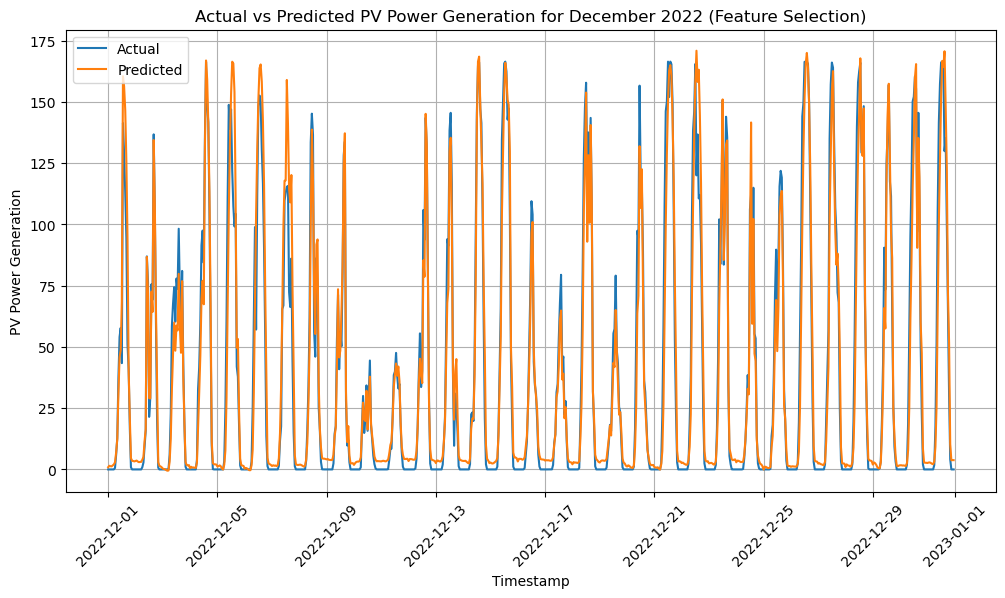

Metrics for December 2022 with Feature Selection:
MAE: 7.735856393992368
MSE: 159.11257981925928
RMSE: 12.613983503210209
R-squared: 0.942047524327813
MAPE: 1.7878176758500368e-14


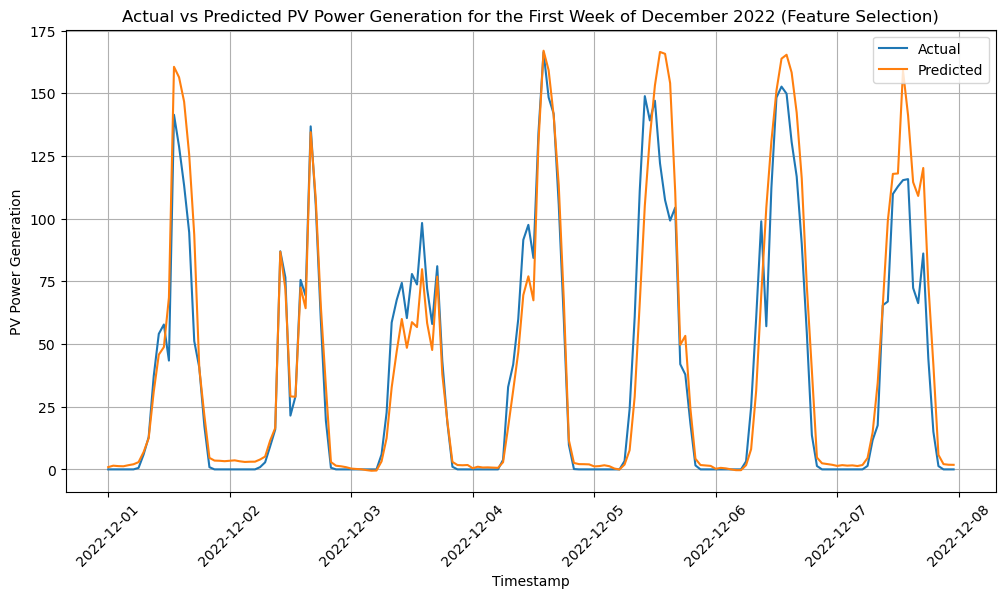

MAE for the First Week of December 2022 with Feature Selection: 9.75392684540752
MSE for the First Week of December 2022 with Feature Selection: 260.7106763923367
RMSE for the First Week of December 2022 with Feature Selection: 16.14653759765036
R-squared for the First Week of December 2022 with Feature Selection: 0.8900302616298056
Mean Absolute Percentage Error (MAPE) for the First Week of December 2022 with Feature Selection: 8.186171233501721


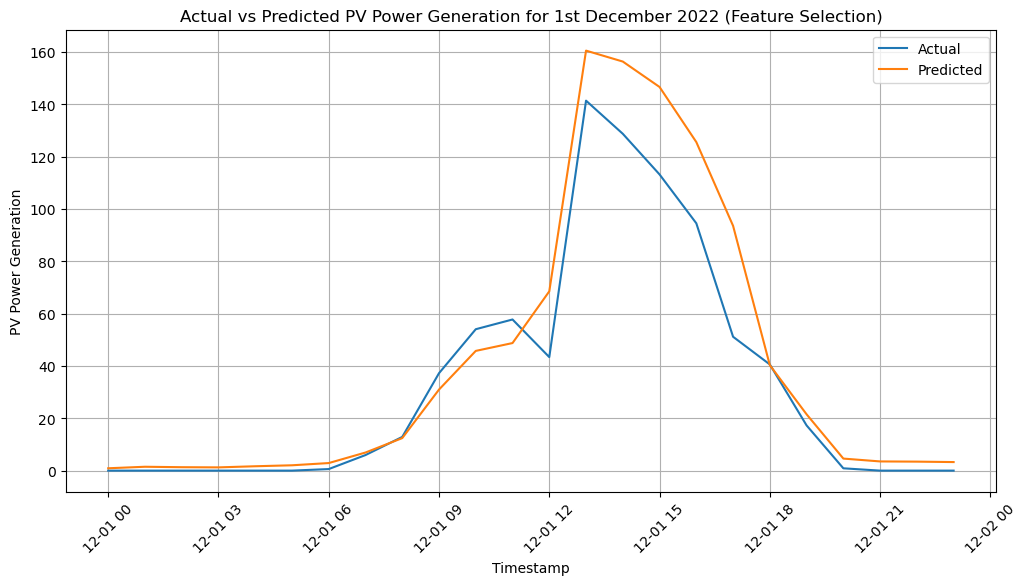

MAE for 1st December 2022 with Feature Selection: 9.714892355683803
MSE for 1st December 2022 with Feature Selection: 246.47360578678288
RMSE for 1st December 2022 with Feature Selection: 15.69947788261708
R-squared for 1st December 2022 with Feature Selection: 0.8713299566017052
Mean Absolute Percentage Error (MAPE) for 1st December 2022 with Feature Selection: 23.07867791071859


In [107]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score

# Filter data for December 2022
december_2022_data = dataset[
    (dataset['Timestamp'].dt.year == 2022) &
    (dataset['Timestamp'].dt.month == 12)
]

X_december_2022 = december_2022_data.iloc[:, 1:-1].values
y_december_2022_actual = december_2022_data.iloc[:, -1].values

k_values = [1, 2, 3, 4, 5, 6, 7, 8]  # You can adjust the range of k values
cv_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X_december_2022, y_december_2022_actual)
    scores = cross_val_score(model, X_selected, y_december_2022_actual, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

optimal_k = k_values[cv_scores.index(max(cv_scores))]

selector = SelectKBest(score_func=f_regression, k=optimal_k)
X_december_2022_selected = selector.fit_transform(X_december_2022, y_december_2022_actual)

model.fit(X_december_2022_selected, y_december_2022_actual)

y_december_2022_pred_selected = model.predict(X_december_2022_selected)

mae_december_2022_selected = metrics.mean_absolute_error(y_december_2022_actual, y_december_2022_pred_selected)
mse_december_2022_selected = metrics.mean_squared_error(y_december_2022_actual, y_december_2022_pred_selected)
rmse_december_2022_selected = np.sqrt(mse_december_2022_selected)
r2_december_2022_selected = metrics.r2_score(y_december_2022_actual, y_december_2022_pred_selected)

average_y_december_2022_pred_selected = np.mean(y_december_2022_pred_selected)
average_y_december_2022_actual = np.mean(y_december_2022_actual)
mape_december_2022_selected = np.abs((average_y_december_2022_actual - average_y_december_2022_pred_selected) / average_y_december_2022_actual) * 100

print("Optimal number of features:", optimal_k)
print("Mean Absolute Error (MAE) after Feature Selection:", mae_december_2022_selected)
print("Mean Squared Error (MSE) after Feature Selection:", mse_december_2022_selected)
print("Root Mean Squared Error (RMSE) after Feature Selection:", rmse_december_2022_selected)
print("R-squared (R2) after Feature Selection:", r2_december_2022_selected)
print("Mean Absolute Percentage Error (MAPE) after Feature Selection:", mape_december_2022_selected)

plt.figure(figsize=(12, 6))
plt.scatter(y_december_2022_actual, y_december_2022_pred_selected)
plt.xlabel('True Values (y_december_2022_actual)')
plt.ylabel('Predicted Values (y_december_2022_pred_selected)')
plt.title('Actual vs Predicted Values after Feature Selection for December 2022')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(december_2022_data['Timestamp'], y_december_2022_actual, label='Actual')
plt.plot(december_2022_data['Timestamp'], y_december_2022_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for December 2022 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for December 2022 with Feature Selection:")
print("MAE:", mae_december_2022_selected)
print("MSE:", mse_december_2022_selected)
print("RMSE:", rmse_december_2022_selected)
print("R-squared:", r2_december_2022_selected)
print("MAPE:", mape_december_2022_selected)



first_week_december_2022_data = dataset[
    (dataset['Timestamp'].dt.year == 2022) &
    (dataset['Timestamp'].dt.month == 12) &
    (dataset['Timestamp'].dt.day <= 7)
]

X_first_week_december_2022 = first_week_december_2022_data.iloc[:, 1:-1].values
y_first_week_december_2022_actual = first_week_december_2022_data.iloc[:, -1].values

X_first_week_december_2022_selected = selector.transform(X_first_week_december_2022)

y_first_week_december_2022_pred_selected = model.predict(X_first_week_december_2022_selected)

mae_first_week_december_2022_selected = metrics.mean_absolute_error(y_first_week_december_2022_actual, y_first_week_december_2022_pred_selected)
mse_first_week_december_2022_selected = metrics.mean_squared_error(y_first_week_december_2022_actual, y_first_week_december_2022_pred_selected)
rmse_first_week_december_2022_selected = np.sqrt(mse_first_week_december_2022_selected)
r2_first_week_december_2022_selected = metrics.r2_score(y_first_week_december_2022_actual, y_first_week_december_2022_pred_selected)

average_y_first_week_december_2022_pred_selected = np.mean(y_first_week_december_2022_pred_selected)
average_y_first_week_december_2022_actual = np.mean(y_first_week_december_2022_actual)
mape_first_week_december_2022_selected = np.abs((average_y_first_week_december_2022_actual - average_y_first_week_december_2022_pred_selected) / average_y_first_week_december_2022_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(first_week_december_2022_data['Timestamp'], y_first_week_december_2022_actual, label='Actual')
plt.plot(first_week_december_2022_data['Timestamp'], y_first_week_december_2022_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of December 2022 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("MAE for the First Week of December 2022 with Feature Selection:", mae_first_week_december_2022_selected)
print("MSE for the First Week of December 2022 with Feature Selection:", mse_first_week_december_2022_selected)
print("RMSE for the First Week of December 2022 with Feature Selection:", rmse_first_week_december_2022_selected)
print("R-squared for the First Week of December 2022 with Feature Selection:", r2_first_week_december_2022_selected)
print("Mean Absolute Percentage Error (MAPE) for the First Week of December 2022 with Feature Selection:", mape_first_week_december_2022_selected)

december_1st_2022_data = dataset[
    (dataset['Timestamp'].dt.year == 2022) &
    (dataset['Timestamp'].dt.month == 12) &
    (dataset['Timestamp'].dt.day == 1)
]

X_december_1st_2022 = december_1st_2022_data.iloc[:, 1:-1].values
y_december_1st_2022_actual = december_1st_2022_data.iloc[:, -1].values

X_december_1st_2022_selected = selector.transform(X_december_1st_2022)

y_december_1st_2022_pred_selected = model.predict(X_december_1st_2022_selected)

mae_december_1st_2022_selected = metrics.mean_absolute_error(y_december_1st_2022_actual, y_december_1st_2022_pred_selected)
mse_december_1st_2022_selected = metrics.mean_squared_error(y_december_1st_2022_actual, y_december_1st_2022_pred_selected)
rmse_december_1st_2022_selected = np.sqrt(mse_december_1st_2022_selected)
r2_december_1st_2022_selected = metrics.r2_score(y_december_1st_2022_actual, y_december_1st_2022_pred_selected)

average_y_december_1st_2022_pred_selected = np.mean(y_december_1st_2022_pred_selected)
average_y_december_1st_2022_actual = np.mean(y_december_1st_2022_actual)
mape_december_1st_2022_selected = np.abs((average_y_december_1st_2022_actual - average_y_december_1st_2022_pred_selected) / average_y_december_1st_2022_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_actual, label='Actual')
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for 1st December 2022 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("MAE for 1st December 2022 with Feature Selection:", mae_december_1st_2022_selected)
print("MSE for 1st December 2022 with Feature Selection:", mse_december_1st_2022_selected)
print("RMSE for 1st December 2022 with Feature Selection:", rmse_december_1st_2022_selected)
print("R-squared for 1st December 2022 with Feature Selection:", r2_december_1st_2022_selected)
print("Mean Absolute Percentage Error (MAPE) for 1st December 2022 with Feature Selection:", mape_december_1st_2022_selected)


March 2023

Optimal number of features: 4
Mean Absolute Error (MAE) after Feature Selection for March 2023: 9.834311741418796
Mean Squared Error (MSE) after Feature Selection for March 2023: 347.9183404333426
Root Mean Squared Error (RMSE) after Feature Selection for March 2023: 18.65256927164037
R-squared (R2) after Feature Selection for March 2023: 0.8585916088957386
Mean Absolute Percentage Error (MAPE) after Feature Selection for March 2023: 0.0


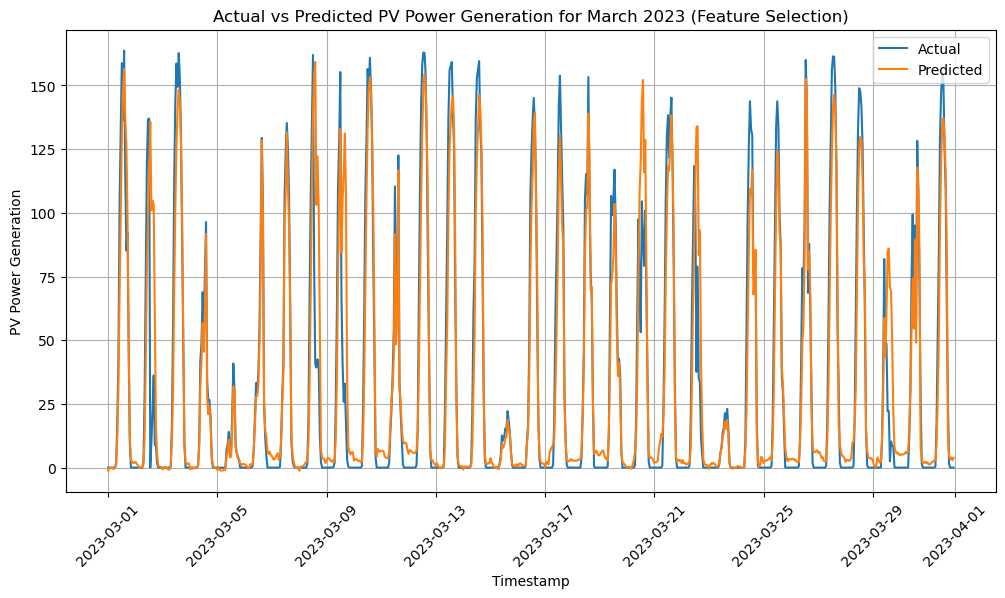

Metrics for March 2023 with Feature Selection:
MAE: 9.834311741418796
MSE: 347.9183404333426
RMSE: 18.65256927164037
R-squared: 0.8585916088957386
Mean Absolute Percentage Error (MAPE): 0.0


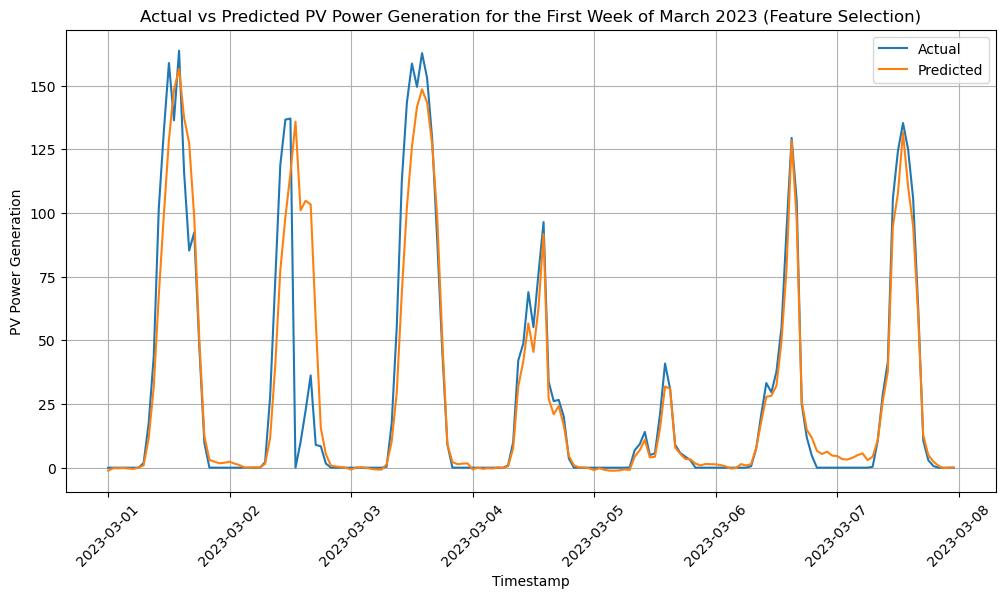

MAE for the First Week of March 2023 with Feature Selection: 7.969853542012602
MSE for the First Week of March 2023 with Feature Selection: 354.7684082644115
RMSE for the First Week of March 2023 with Feature Selection: 18.83529687221339
R-squared for the First Week of March 2023 with Feature Selection: 0.8375225952851295
Mean Absolute Percentage Error (MAPE) for the First Week of March 2023 with Feature Selection: 0.8417612922751712


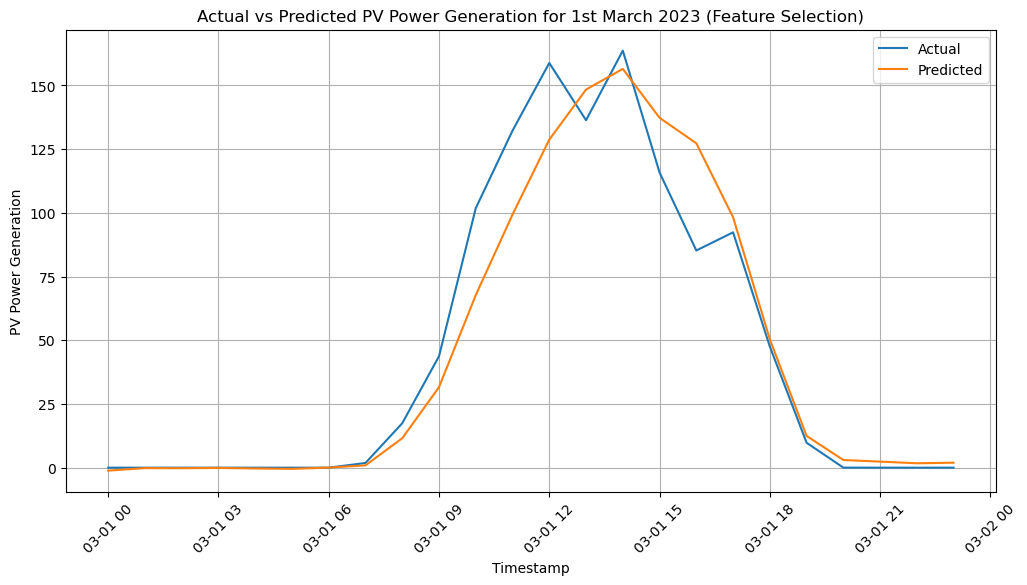

MAE for 1st March 2023 with Feature Selection: 9.237869984870418
MSE for 1st March 2023 with Feature Selection: 243.15680269089364
RMSE for 1st March 2023 with Feature Selection: 15.593485905688107
R-squared for 1st March 2023 with Feature Selection: 0.9281354998127356
Mean Absolute Percentage Error (MAPE) for 1st March 2023 with Feature Selection: 2.6714848419188866


In [108]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

march_2023_data = dataset[
    (dataset['Timestamp'].dt.year == 2023) &
    (dataset['Timestamp'].dt.month == 3)
]

X_march_2023 = march_2023_data.iloc[:, 1:-1].values
y_march_2023_actual = march_2023_data.iloc[:, -1].values

k_values = [1, 2, 3, 4, 5, 6, 7, 8]  # You can adjust the range of k values
cv_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X_march_2023, y_march_2023_actual)
    scores = cross_val_score(model, X_selected, y_march_2023_actual, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

optimal_k = k_values[cv_scores.index(max(cv_scores))]


selector = SelectKBest(score_func=f_regression, k=optimal_k)
X_march_2023_selected = selector.fit_transform(X_march_2023, y_march_2023_actual)

model.fit(X_march_2023_selected, y_march_2023_actual)

y_march_2023_pred_selected = model.predict(X_march_2023_selected)

mae_march_2023_selected = metrics.mean_absolute_error(y_march_2023_actual, y_march_2023_pred_selected)
mse_march_2023_selected = metrics.mean_squared_error(y_march_2023_actual, y_march_2023_pred_selected)
rmse_march_2023_selected = np.sqrt(mse_march_2023_selected)
r2_march_2023_selected = metrics.r2_score(y_march_2023_actual, y_march_2023_pred_selected)

average_y_march_2023_pred_selected = np.mean(y_march_2023_pred_selected)
average_y_march_2023_actual = np.mean(y_march_2023_actual)
mape_march_2023_selected = np.abs((average_y_march_2023_actual - average_y_march_2023_pred_selected) / average_y_march_2023_actual) * 100

print("Optimal number of features:", optimal_k)
print("Mean Absolute Error (MAE) after Feature Selection for March 2023:", mae_march_2023_selected)
print("Mean Squared Error (MSE) after Feature Selection for March 2023:", mse_march_2023_selected)
print("Root Mean Squared Error (RMSE) after Feature Selection for March 2023:", rmse_march_2023_selected)
print("R-squared (R2) after Feature Selection for March 2023:", r2_march_2023_selected)
print("Mean Absolute Percentage Error (MAPE) after Feature Selection for March 2023:", mape_march_2023_selected)

plt.figure(figsize=(12, 6))
plt.scatter(y_march_2023_actual, y_march_2023_pred_selected)
plt.xlabel('True Values (y_march_2023_actual)')
plt.ylabel('Predicted Values (y_march_2023_pred_selected)')
plt.title('Actual vs Predicted Values after Feature Selection for March 2023')
plt.show()



plt.figure(figsize=(12, 6))
plt.plot(march_2023_data['Timestamp'], y_march_2023_actual, label='Actual')
plt.plot(march_2023_data['Timestamp'], y_march_2023_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for March 2023 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


print("Metrics for March 2023 with Feature Selection:")
print("MAE:", mae_march_2023_selected)
print("MSE:", mse_march_2023_selected)
print("RMSE:", rmse_march_2023_selected)
print("R-squared:", r2_march_2023_selected)
print("Mean Absolute Percentage Error (MAPE):", mape_march_2023_selected)


first_week_march_2023_data = dataset[
    (dataset['Timestamp'].dt.year == 2023) &
    (dataset['Timestamp'].dt.month == 3) &
    (dataset['Timestamp'].dt.day <= 7)
]


X_first_week_march_2023 = first_week_march_2023_data.iloc[:, 1:-1].values
y_first_week_march_2023_actual = first_week_march_2023_data.iloc[:, -1].values


X_first_week_march_2023_selected = selector.transform(X_first_week_march_2023)


y_first_week_march_2023_pred_selected = model.predict(X_first_week_march_2023_selected)


mae_first_week_march_2023_selected = metrics.mean_absolute_error(y_first_week_march_2023_actual, y_first_week_march_2023_pred_selected)
mse_first_week_march_2023_selected = metrics.mean_squared_error(y_first_week_march_2023_actual, y_first_week_march_2023_pred_selected)
rmse_first_week_march_2023_selected = np.sqrt(mse_first_week_march_2023_selected)
r2_first_week_march_2023_selected = metrics.r2_score(y_first_week_march_2023_actual, y_first_week_march_2023_pred_selected)


average_y_first_week_march_2023_pred_selected = np.mean(y_first_week_march_2023_pred_selected)
average_y_first_week_march_2023_actual = np.mean(y_first_week_march_2023_actual)
mape_first_week_march_2023_selected = np.abs((average_y_first_week_march_2023_actual - average_y_first_week_march_2023_pred_selected) / average_y_first_week_march_2023_actual) * 100


plt.figure(figsize=(12, 6))
plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_actual, label='Actual')
plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of March 2023 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


print("MAE for the First Week of March 2023 with Feature Selection:", mae_first_week_march_2023_selected)
print("MSE for the First Week of March 2023 with Feature Selection:", mse_first_week_march_2023_selected)
print("RMSE for the First Week of March 2023 with Feature Selection:", rmse_first_week_march_2023_selected)
print("R-squared for the First Week of March 2023 with Feature Selection:", r2_first_week_march_2023_selected)
print("Mean Absolute Percentage Error (MAPE) for the First Week of March 2023 with Feature Selection:", mape_first_week_march_2023_selected)


march_1st_2023_data = dataset[
    (dataset['Timestamp'].dt.year == 2023) &
    (dataset['Timestamp'].dt.month == 3) &
    (dataset['Timestamp'].dt.day == 1)
]


X_march_1st_2023 = march_1st_2023_data.iloc[:, 1:-1].values
y_march_1st_2023_actual = march_1st_2023_data.iloc[:, -1].values


X_march_1st_2023_selected = selector.transform(X_march_1st_2023)


y_march_1st_2023_pred_selected = model.predict(X_march_1st_2023_selected)

mae_march_1st_2023_selected = metrics.mean_absolute_error(y_march_1st_2023_actual, y_march_1st_2023_pred_selected)
mse_march_1st_2023_selected = metrics.mean_squared_error(y_march_1st_2023_actual, y_march_1st_2023_pred_selected)
rmse_march_1st_2023_selected = np.sqrt(mse_march_1st_2023_selected)
r2_march_1st_2023_selected = metrics.r2_score(y_march_1st_2023_actual, y_march_1st_2023_pred_selected)

average_y_march_1st_2023_pred_selected = np.mean(y_march_1st_2023_pred_selected)
average_y_march_1st_2023_actual = np.mean(y_march_1st_2023_actual)
mape_march_1st_2023_selected = np.abs((average_y_march_1st_2023_actual - average_y_march_1st_2023_pred_selected) / average_y_march_1st_2023_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(march_1st_2023_data['Timestamp'], y_march_1st_2023_actual, label='Actual')
plt.plot(march_1st_2023_data['Timestamp'], y_march_1st_2023_pred_selected, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for 1st March 2023 (Feature Selection)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("MAE for 1st March 2023 with Feature Selection:", mae_march_1st_2023_selected)
print("MSE for 1st March 2023 with Feature Selection:", mse_march_1st_2023_selected)
print("RMSE for 1st March 2023 with Feature Selection:", rmse_march_1st_2023_selected)
print("R-squared for 1st March 2023 with Feature Selection:", r2_march_1st_2023_selected)
print("Mean Absolute Percentage Error (MAPE) for 1st March 2023 with Feature Selection:", mape_march_1st_2023_selected)


# Polynomial regression

In [109]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# List to store evaluation metrics for each k
mae_scores = []
mse_scores = []
r2_scores = []

# List of k values
k_values = [1, 2, 3, 4, 5, 6, 7, 8]

poly_degree = 2

poly_features = PolynomialFeatures(degree=poly_degree)

for k in k_values:

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)


    X_train_poly = poly_features.fit_transform(X_train_selected)
    X_test_poly = poly_features.transform(X_test_selected)


    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)


    y_pred_poly = poly_model.predict(X_test_poly)


    mae = mean_absolute_error(y_test, y_pred_poly)
    mse = mean_squared_error(y_test, y_pred_poly)
    r2 = r2_score(y_test, y_pred_poly)


    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"For k = {k}:")
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("R^2 Score:", r2)
    print("---")

best_k = k_values[mae_scores.index(min(mae_scores))]
print("Best k based on Minimum MAE:", best_k)


For k = 1:
Mean Absolute Error: 7.574921255113538
Mean Squared Error: 235.53276411562638
R^2 Score: 0.8949679528052967
---
For k = 2:
Mean Absolute Error: 7.589564043705118
Mean Squared Error: 236.26264614174013
R^2 Score: 0.8946424736571994
---
For k = 3:
Mean Absolute Error: 7.57426490381337
Mean Squared Error: 234.3626200131557
R^2 Score: 0.8954897597439482
---
For k = 4:
Mean Absolute Error: 7.618005651662646
Mean Squared Error: 233.48029546849452
R^2 Score: 0.8958832181808831
---
For k = 5:
Mean Absolute Error: 7.619291321417376
Mean Squared Error: 231.49439210283902
R^2 Score: 0.896768799840016
---
For k = 6:
Mean Absolute Error: 7.700369764207567
Mean Squared Error: 230.18393930669254
R^2 Score: 0.8973531751834978
---
For k = 7:
Mean Absolute Error: 7.711025618614948
Mean Squared Error: 230.2239682284833
R^2 Score: 0.8973353249297614
---
For k = 8:
Mean Absolute Error: 7.74780917215699
Mean Squared Error: 228.66720982435615
R^2 Score: 0.8980295362968592
---
Best k based on Minim

In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Polynomial Regression
poly_degree = 2

poly_features = PolynomialFeatures(degree=poly_degree)
X_train_poly = poly_features.fit_transform(X_train_selected)
X_test_poly = poly_features.transform(X_test_selected)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_pred_poly = poly_model.predict(X_test_poly)

In [186]:
average_y_test = np.mean(y_test)
average_y_pred_poly = np.mean(y_pred_poly)
mape_poly = np.abs((average_y_test - average_y_pred_poly) / average_y_test) * 100

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_poly)
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred_poly)')
plt.title('Actual vs Predicted Values after Polynomial Regression')
plt.show()

mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print("MAE after Polynomial Regression:", mae_poly)
print("MSE after Polynomial Regression:", mse_poly)
print("RMSE after Polynomial Regression:", rmse_poly)
print("R-squared after Polynomial Regression:", r2_poly)
print("Mean Absolute Percentage Error (MAPE) after Polynomial Regression:", mape_poly)

MAE after Polynomial Regression: 7.74780917215699
MSE after Polynomial Regression: 228.66720982435615
RMSE after Polynomial Regression: 15.12174625578528
R-squared after Polynomial Regression: 0.8980295362968592
Mean Absolute Percentage Error (MAPE) after Polynomial Regression: 0.3243148729307087


October 2022

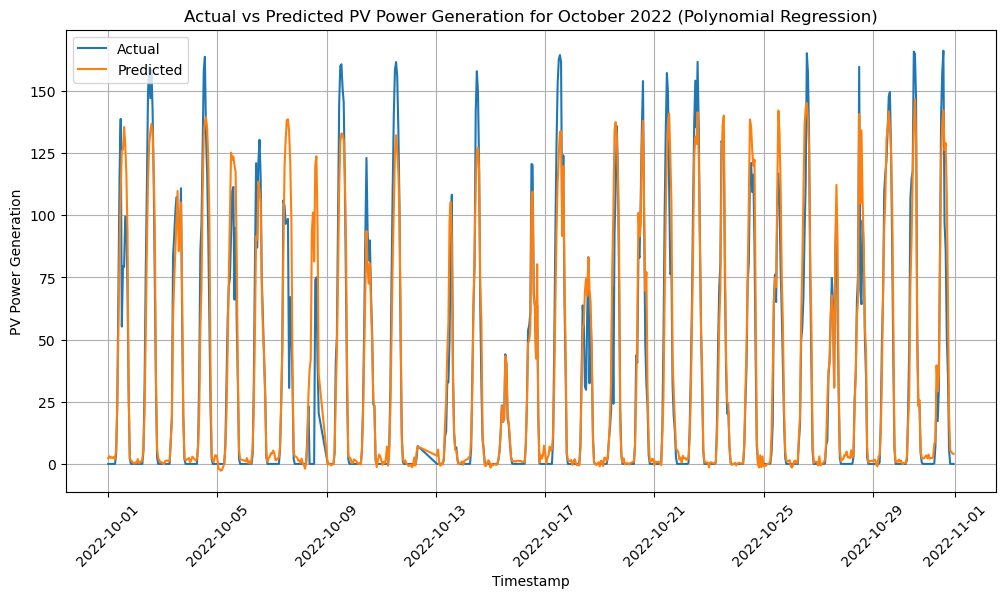

Metrics for October 2022 (Polynomial Regression):
MAE: 8.58760718822018
MSE: 261.14109185010756
RMSE: 16.159860514562233
R-squared: 0.8889524263975478


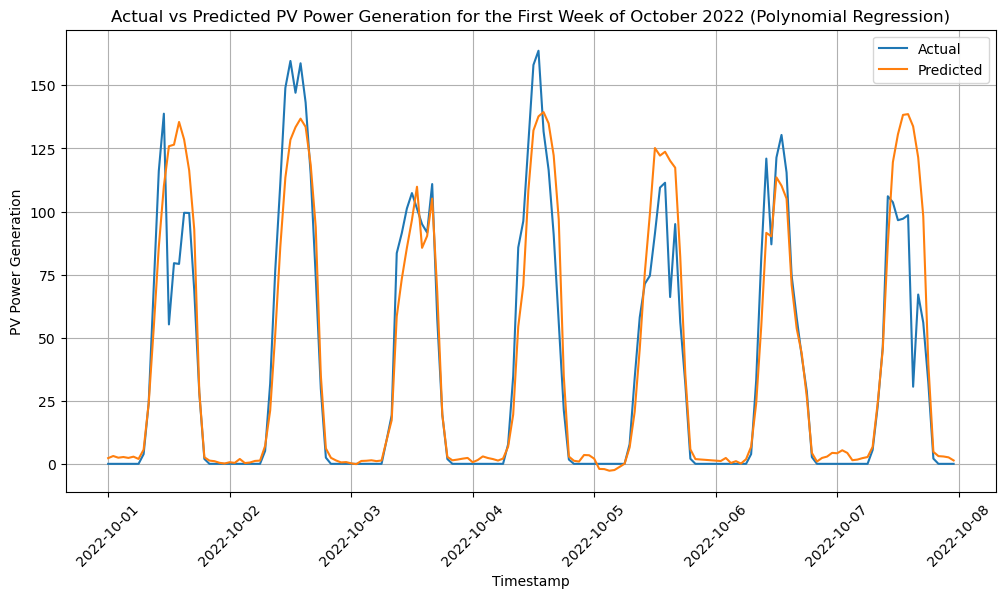

Metrics for the First Week of October 2022 (Polynomial Regression):
MAE: 10.591860610738697
MSE: 347.7366420428685
RMSE: 18.647698036027624
R-squared: 0.8568044378962727


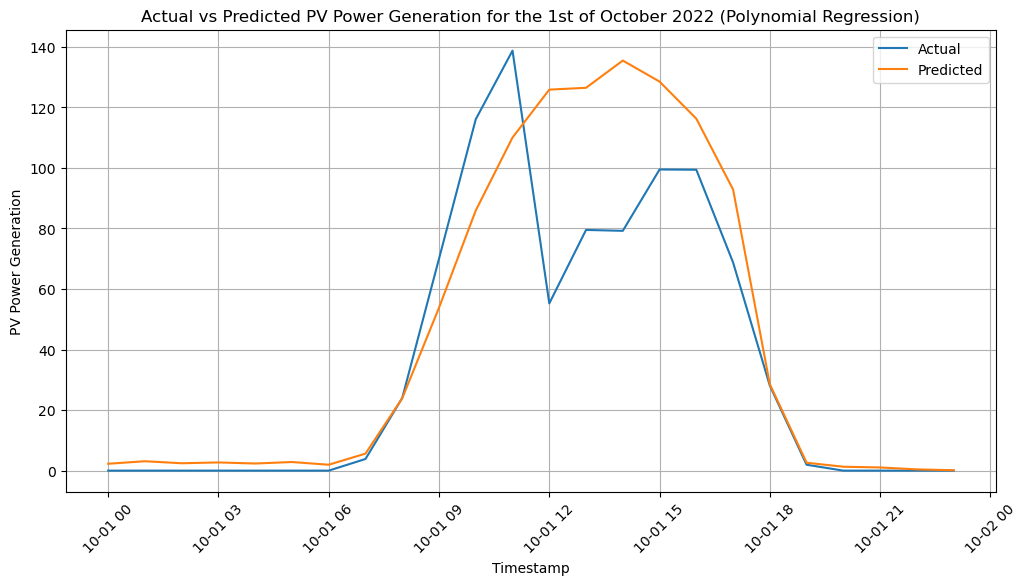

Metrics for the 1st of October 2022 (Polynomial Regression):
MAE: 14.266444979425097
MSE: 588.0912315149113
RMSE: 24.250592395133594
R-squared: 0.7062616699057935


In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert 'Timestamp' column to datetime
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])

october_data = dataset[(dataset['Timestamp'].dt.year == 2022) & (dataset['Timestamp'].dt.month == 10)]

X_october = october_data.iloc[:, 1:-1].values  # Features
y_october_actual = october_data.iloc[:, -1].values  # Actual PV power generation


X_october_poly = poly_features.transform(X_october)

y_october_pred_poly = poly_model.predict(X_october_poly)

mae_october_poly = mean_absolute_error(y_october_actual, y_october_pred_poly)
mse_october_poly = mean_squared_error(y_october_actual, y_october_pred_poly)
rmse_october_poly = np.sqrt(mse_october_poly)
r2_october_poly = r2_score(y_october_actual, y_october_pred_poly)

plt.figure(figsize=(12, 6))
plt.plot(october_data['Timestamp'], y_october_actual, label='Actual')
plt.plot(october_data['Timestamp'], y_october_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for October 2022 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for October 2022 (Polynomial Regression):")
print("MAE:", mae_october_poly)
print("MSE:", mse_october_poly)
print("RMSE:", rmse_october_poly)
print("R-squared:", r2_october_poly)

october_first_week_data = dataset[
    (dataset['Timestamp'].dt.year == 2022) &
    (dataset['Timestamp'].dt.month == 10) &
    (dataset['Timestamp'].dt.day <= 7)
]

X_october_first_week = october_first_week_data.iloc[:, 1:-1].values  # Features
y_october_first_week_actual = october_first_week_data.iloc[:, -1].values  # Actual PV power generation

X_october_first_week_poly = poly_features.transform(X_october_first_week)

y_october_first_week_pred_poly = poly_model.predict(X_october_first_week_poly)

mae_october_first_week_poly = mean_absolute_error(y_october_first_week_actual, y_october_first_week_pred_poly)
mse_october_first_week_poly = mean_squared_error(y_october_first_week_actual, y_october_first_week_pred_poly)
rmse_october_first_week_poly = np.sqrt(mse_october_first_week_poly)
r2_october_first_week_poly = r2_score(y_october_first_week_actual, y_october_first_week_pred_poly)

plt.figure(figsize=(12, 6))
plt.plot(october_first_week_data['Timestamp'], y_october_first_week_actual, label='Actual')
plt.plot(october_first_week_data['Timestamp'], y_october_first_week_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of October 2022 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for the First Week of October 2022 (Polynomial Regression):")
print("MAE:", mae_october_first_week_poly)
print("MSE:", mse_october_first_week_poly)
print("RMSE:", rmse_october_first_week_poly)
print("R-squared:", r2_october_first_week_poly)

october_1st_data = dataset[
    (dataset['Timestamp'].dt.year == 2022) &
    (dataset['Timestamp'].dt.month == 10) &
    (dataset['Timestamp'].dt.day == 1)
]

X_october_1st = october_1st_data.iloc[:, 1:-1].values  # Features
y_october_1st_actual = october_1st_data.iloc[:, -1].values  # Actual PV power generation

X_october_1st_poly = poly_features.transform(X_october_1st)

y_october_1st_pred_poly = poly_model.predict(X_october_1st_poly)

mae_october_1st_poly = mean_absolute_error(y_october_1st_actual, y_october_1st_pred_poly)
mse_october_1st_poly = mean_squared_error(y_october_1st_actual, y_october_1st_pred_poly)
rmse_october_1st_poly = np.sqrt(mse_october_1st_poly)
r2_october_1st_poly = r2_score(y_october_1st_actual, y_october_1st_pred_poly)

plt.figure(figsize=(12, 6))
plt.plot(october_1st_data['Timestamp'], y_october_1st_actual, label='Actual')
plt.plot(october_1st_data['Timestamp'], y_october_1st_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the 1st of October 2022 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for the 1st of October 2022 (Polynomial Regression):")
print("MAE:", mae_october_1st_poly)
print("MSE:", mse_october_1st_poly)
print("RMSE:", rmse_october_1st_poly)
print("R-squared:", r2_october_1st_poly)


December 2022

In [122]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Polynomial Regression
poly_degree = 2

# Create polynomial features for December 2022
poly_features = PolynomialFeatures(degree=poly_degree)
X_december_2022_poly = poly_features.fit_transform(X_december_2022_selected)
X_first_week_december_2022_poly = poly_features.transform(X_first_week_december_2022_selected)
X_december_1st_2022_poly = poly_features.transform(X_december_1st_2022_selected)

# Initialize and train the polynomial regression models
poly_model_december_2022 = LinearRegression()
poly_model_december_2022.fit(X_december_2022_poly, y_december_2022_actual)

poly_model_first_week_december_2022 = LinearRegression()
poly_model_first_week_december_2022.fit(X_first_week_december_2022_poly, y_first_week_december_2022_actual)

poly_model_december_1st_2022 = LinearRegression()
poly_model_december_1st_2022.fit(X_december_1st_2022_poly, y_december_1st_2022_actual)


y_december_2022_pred_poly = poly_model_december_2022.predict(X_december_2022_poly)
y_first_week_december_2022_pred_poly = poly_model_first_week_december_2022.predict(X_first_week_december_2022_poly)
y_december_1st_2022_pred_poly = poly_model_december_1st_2022.predict(X_december_1st_2022_poly)

# Calculate metrics for December 2022
mae_december_2022_poly = mean_absolute_error(y_december_2022_actual, y_december_2022_pred_poly)
mse_december_2022_poly = mean_squared_error(y_december_2022_actual, y_december_2022_pred_poly)
rmse_december_2022_poly = np.sqrt(mse_december_2022_poly)
r2_december_2022_poly = r2_score(y_december_2022_actual, y_december_2022_pred_poly)

average_y_december_2022_actual = np.mean(y_december_2022_actual)
average_y_december_2022_pred_poly = np.mean(y_december_2022_pred_poly)
mape_december_2022_poly = np.abs((average_y_december_2022_actual - average_y_december_2022_pred_poly) / average_y_december_2022_actual) * 100

# Calculate metrics for the first week of December 2022
mae_first_week_december_2022_poly = mean_absolute_error(y_first_week_december_2022_actual, y_first_week_december_2022_pred_poly)
mse_first_week_december_2022_poly = mean_squared_error(y_first_week_december_2022_actual, y_first_week_december_2022_pred_poly)
rmse_first_week_december_2022_poly = np.sqrt(mse_first_week_december_2022_poly)
r2_first_week_december_2022_poly = r2_score(y_first_week_december_2022_actual, y_first_week_december_2022_pred_poly)

average_y_first_week_december_2022_actual = np.mean(y_first_week_december_2022_actual)
average_y_first_week_december_2022_pred_poly = np.mean(y_first_week_december_2022_pred_poly)
mape_first_week_december_2022_poly = np.abs((average_y_first_week_december_2022_actual - average_y_first_week_december_2022_pred_poly) / average_y_first_week_december_2022_actual) * 100

# Calculate metrics for 1st December 2022
mae_december_1st_2022_poly = mean_absolute_error(y_december_1st_2022_actual, y_december_1st_2022_pred_poly)
mse_december_1st_2022_poly = mean_squared_error(y_december_1st_2022_actual, y_december_1st_2022_pred_poly)
rmse_december_1st_2022_poly = np.sqrt(mse_december_1st_2022_poly)
r2_december_1st_2022_poly = r2_score(y_december_1st_2022_actual, y_december_1st_2022_pred_poly)

average_y_december_1st_2022_actual = np.mean(y_december_1st_2022_actual)
average_y_december_1st_2022_pred_poly = np.mean(y_december_1st_2022_pred_poly)
mape_december_1st_2022_poly = np.abs((average_y_december_1st_2022_actual - average_y_december_1st_2022_pred_poly) / average_y_december_1st_2022_actual) * 100

# Plotting for December 2022 (Polynomial Regression)
plt.figure(figsize=(12, 6))
plt.plot(december_2022_data['Timestamp'], y_december_2022_actual, label='Actual')
plt.plot(december_2022_data['Timestamp'], y_december_2022_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for December 2022 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Print metrics for December 2022, the first week of December 2022, and 1st December 2022
print("Metrics for December 2022 (Polynomial Regression):")
print("MAE:", mae_december_2022_poly)
print("MSE:", mse_december_2022_poly)
print("RMSE:", rmse_december_2022_poly)
print("R-squared:", r2_december_2022_poly)
print("MAPE:", mape_december_2022_poly)

# Plotting for the first week of December 2022 (Polynomial Regression)
plt.figure(figsize=(12, 6))
plt.plot(first_week_december_2022_data['Timestamp'], y_first_week_december_2022_actual, label='Actual')
plt.plot(first_week_december_2022_data['Timestamp'], y_first_week_december_2022_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of December 2022 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


print("\nMetrics for the First Week of December 2022 (Polynomial Regression):")
print("MAE:", mae_first_week_december_2022_poly)
print("MSE:", mse_first_week_december_2022_poly)
print("RMSE:", rmse_first_week_december_2022_poly)
print("R-squared:", r2_first_week_december_2022_poly)
print("MAPE:", mape_first_week_december_2022_poly)

# Plotting for 1st December 2022 (Polynomial Regression)
plt.figure(figsize=(12, 6))
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_actual, label='Actual')
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for 1st December 2022 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("\nMetrics for 1st December 2022 (Polynomial Regression):")
print("MAE:", mae_december_1st_2022_poly)
print("MSE:", mse_december_1st_2022_poly)
print("RMSE:", rmse_december_1st_2022_poly)
print("R-squared:", r2_december_1st_2022_poly)
print("MAPE:", mape_december_1st_2022_poly)


Metrics for December 2022 (Polynomial Regression):
MAE: 6.568059639721052
MSE: 133.2325918673977
RMSE: 11.542642326061989
R-squared: 0.9514736135401206
MAPE: 3.575635351700073e-13



Metrics for the First Week of December 2022 (Polynomial Regression):
MAE: 7.428407982393383
MSE: 143.07927762936947
RMSE: 11.96157504801811
R-squared: 0.9396480767691312
MAPE: 5.2786414258056184e-14



Metrics for 1st December 2022 (Polynomial Regression):
MAE: 4.299785522595115
MSE: 42.1398574580515
RMSE: 6.491521967770848
R-squared: 0.9780011442985259
MAPE: 6.397355600441572e-14


March 2023

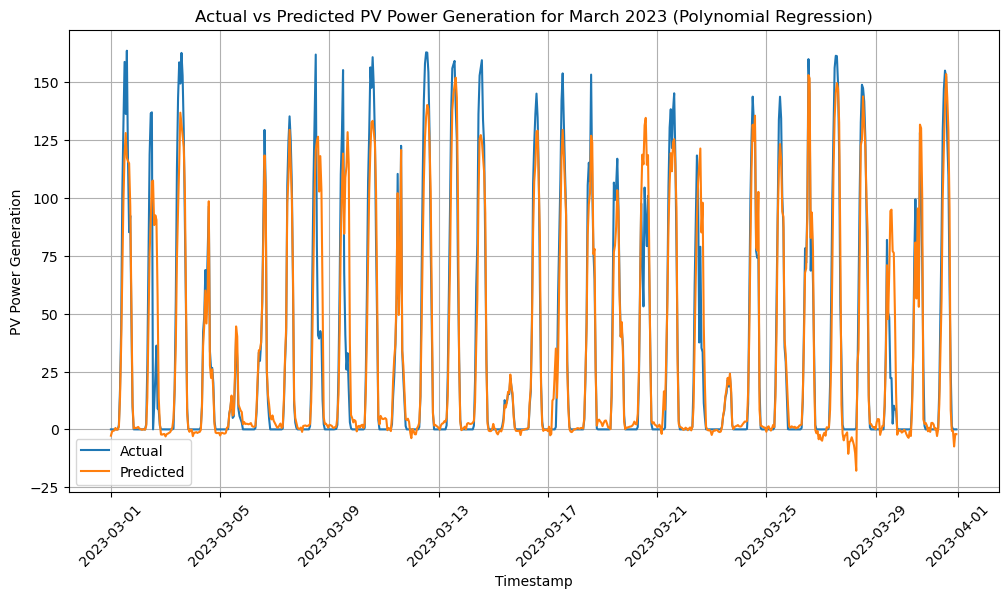

Metrics for March 2023 (Polynomial Regression):
MAE: 8.824893782578295
MSE: 300.3869230887558
RMSE: 17.331673984031543
R-squared: 0.8779103411167293


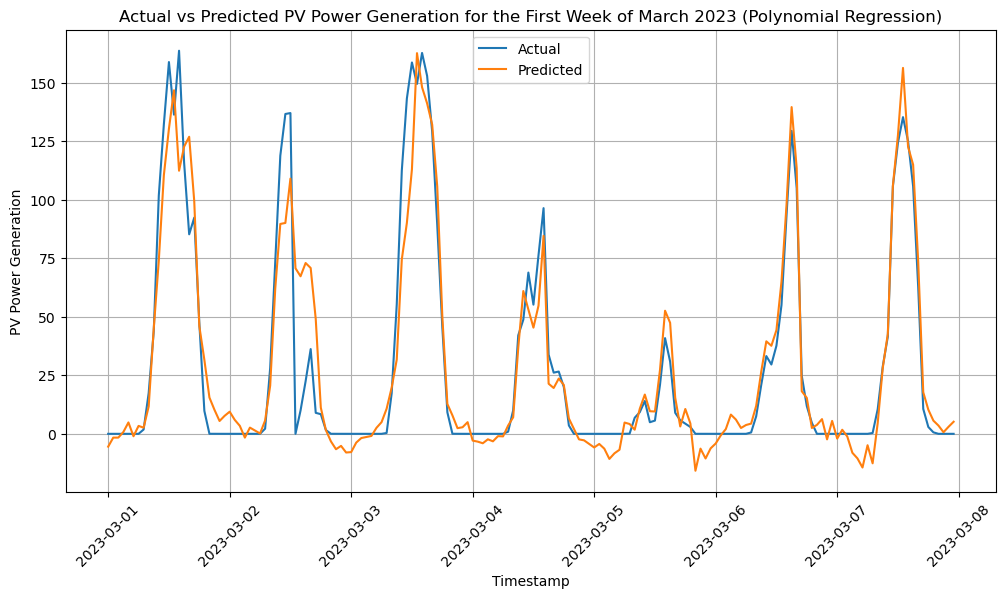


Metrics for the First Week of March 2023 (Polynomial Regression):
MAE: 9.291284365550393
MSE: 230.91591822686635
RMSE: 15.195917814560143
R-squared: 0.8942447573491673



Metrics for 1st March 2023 (Polynomial Regression):
MAE: 3.2773681595260395
MSE: 15.794269777969603
RMSE: 3.9742005206040627
R-squared: 0.9953320355801046
MAPE for March 2023 (Polynomial Regression): 1.0458985242966806e-12
MAPE for the First Week of March 2023 (Polynomial Regression): 4.359081194643736e-12
MAPE for 1st March 2023 (Polynomial Regression): 2.189843604511061e-11


In [123]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Polynomial Regression
poly_degree = 2

# Create polynomial features for March 2023
poly_features = PolynomialFeatures(degree=poly_degree)
X_march_2023_poly = poly_features.fit_transform(X_march_2023_selected)
X_first_week_march_2023_poly = poly_features.transform(X_first_week_march_2023_selected)
X_march_1st_2023_poly = poly_features.transform(X_march_1st_2023_selected)

# Initialize and train the polynomial regression models for March 2023
poly_model_march_2023 = LinearRegression()
poly_model_march_2023.fit(X_march_2023_poly, y_march_2023_actual)

poly_model_first_week_march_2023 = LinearRegression()
poly_model_first_week_march_2023.fit(X_first_week_march_2023_poly, y_first_week_march_2023_actual)

poly_model_march_1st_2023 = LinearRegression()
poly_model_march_1st_2023.fit(X_march_1st_2023_poly, y_march_1st_2023_actual)

# Predict using the models with polynomial features for March 2023
y_march_2023_pred_poly = poly_model_march_2023.predict(X_march_2023_poly)
y_first_week_march_2023_pred_poly = poly_model_first_week_march_2023.predict(X_first_week_march_2023_poly)
y_march_1st_2023_pred_poly = poly_model_march_1st_2023.predict(X_march_1st_2023_poly)

# Calculate metrics for March 2023
mae_march_2023_poly = mean_absolute_error(y_march_2023_actual, y_march_2023_pred_poly)
mse_march_2023_poly = mean_squared_error(y_march_2023_actual, y_march_2023_pred_poly)
rmse_march_2023_poly = np.sqrt(mse_march_2023_poly)
r2_march_2023_poly = r2_score(y_march_2023_actual, y_march_2023_pred_poly)

# Calculate metrics for the first week of March 2023
mae_first_week_march_2023_poly = mean_absolute_error(y_first_week_march_2023_actual, y_first_week_march_2023_pred_poly)
mse_first_week_march_2023_poly = mean_squared_error(y_first_week_march_2023_actual, y_first_week_march_2023_pred_poly)
rmse_first_week_march_2023_poly = np.sqrt(mse_first_week_march_2023_poly)
r2_first_week_march_2023_poly = r2_score(y_first_week_march_2023_actual, y_first_week_march_2023_pred_poly)

# Calculate metrics for 1st March 2023
mae_march_1st_2023_poly = mean_absolute_error(y_march_1st_2023_actual, y_march_1st_2023_pred_poly)
mse_march_1st_2023_poly = mean_squared_error(y_march_1st_2023_actual, y_march_1st_2023_pred_poly)
rmse_march_1st_2023_poly = np.sqrt(mse_march_1st_2023_poly)
r2_march_1st_2023_poly = r2_score(y_march_1st_2023_actual, y_march_1st_2023_pred_poly)

# Plotting for March 2023 (Polynomial Regression)
plt.figure(figsize=(12, 6))
plt.plot(march_2023_data['Timestamp'], y_march_2023_actual, label='Actual')
plt.plot(march_2023_data['Timestamp'], y_march_2023_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for March 2023 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Print metrics for March 2023, the first week of March 2023, and 1st March 2023
print("Metrics for March 2023 (Polynomial Regression):")
print("MAE:", mae_march_2023_poly)
print("MSE:", mse_march_2023_poly)
print("RMSE:", rmse_march_2023_poly)
print("R-squared:", r2_march_2023_poly)

# Plotting for the first week of March 2023 (Polynomial Regression)
plt.figure(figsize=(12, 6))
plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_actual, label='Actual')
plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of March 2023 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("\nMetrics for the First Week of March 2023 (Polynomial Regression):")
print("MAE:", mae_first_week_march_2023_poly)
print("MSE:", mse_first_week_march_2023_poly)
print("RMSE:", rmse_first_week_march_2023_poly)
print("R-squared:", r2_first_week_march_2023_poly)

# Plotting for 1st March 2023 (Polynomial Regression)
plt.figure(figsize=(12, 6))
plt.plot(march_1st_2023_data['Timestamp'], y_march_1st_2023_actual, label='Actual')
plt.plot(march_1st_2023_data['Timestamp'], y_march_1st_2023_pred_poly, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for 1st March 2023 (Polynomial Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("\nMetrics for 1st March 2023 (Polynomial Regression):")
print("MAE:", mae_march_1st_2023_poly)
print("MSE:", mse_march_1st_2023_poly)
print("RMSE:", rmse_march_1st_2023_poly)
print("R-squared:", r2_march_1st_2023_poly)

# Calculate MAPE for March 2023
average_y_march_2023_actual = np.mean(y_march_2023_actual)
average_y_march_2023_pred_poly = np.mean(y_march_2023_pred_poly)
mape_march_2023_poly = np.abs((average_y_march_2023_actual - average_y_march_2023_pred_poly) / average_y_march_2023_actual) * 100

# Calculate MAPE for the first week of March 2023
average_y_first_week_march_2023_actual = np.mean(y_first_week_march_2023_actual)
average_y_first_week_march_2023_pred_poly = np.mean(y_first_week_march_2023_pred_poly)
mape_first_week_march_2023_poly = np.abs((average_y_first_week_march_2023_actual - average_y_first_week_march_2023_pred_poly) / average_y_first_week_march_2023_actual) * 100

# Calculate MAPE for 1st March 2023
average_y_march_1st_2023_actual = np.mean(y_march_1st_2023_actual)
average_y_march_1st_2023_pred_poly = np.mean(y_march_1st_2023_pred_poly)
mape_march_1st_2023_poly = np.abs((average_y_march_1st_2023_actual - average_y_march_1st_2023_pred_poly) / average_y_march_1st_2023_actual) * 100

# Print MAPE for March 2023, the first week of March 2023, and 1st March 2023
print("MAPE for March 2023 (Polynomial Regression):", mape_march_2023_poly)
print("MAPE for the First Week of March 2023 (Polynomial Regression):", mape_first_week_march_2023_poly)
print("MAPE for 1st March 2023 (Polynomial Regression):", mape_march_1st_2023_poly)






# Ridge Regression

In [125]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alphas = [0.1, 1, 10, 100]

param_grid = {'alpha': alphas}

ridge_model = Ridge()

grid_search = GridSearchCV(ridge_model, param_grid, cv=5)
grid_search.fit(X_train_poly, y_train)

best_alpha = grid_search.best_params_['alpha']

print("Grid Search Results:")
for alpha, score in zip(alphas, grid_search.cv_results_['mean_test_score']):
    print("Alpha:", alpha, "- Mean MAE:", -score)

ridge_model = Ridge(alpha=best_alpha)

ridge_model.fit(X_train_poly, y_train)

y_pred_ridge = ridge_model.predict(X_test_poly)


Grid Search Results:
Alpha: 0.1 - Mean MAE: -0.9049633307903514
Alpha: 1 - Mean MAE: -0.9049039832950037
Alpha: 10 - Mean MAE: -0.904820450290417
Alpha: 100 - Mean MAE: -0.9047462449942444


C:\Users\isaac_knss\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.08932e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\isaac_knss\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.08932e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [126]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define alpha values to be tested
alphas = [0.1, 1, 10, 100]

param_grid = {'alpha': alphas}

ridge_model = Ridge()

grid_search = GridSearchCV(ridge_model, param_grid, cv=5)
grid_search.fit(X_train_poly, y_train)

best_alpha = grid_search.best_params_['alpha']

ridge_model = Ridge(alpha=best_alpha)

ridge_model.fit(X_train_poly, y_train)

y_pred_ridge = ridge_model.predict(X_test_poly)


C:\Users\isaac_knss\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.08932e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\isaac_knss\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.08932e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [127]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Read the CSV file with Pandas
columns_to_include = list(range(10))
dataset = pd.read_csv('combined_data.csv', delimiter=';', usecols=columns_to_include)

X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

alphas = [0.1, 1, 10, 100]
param_grid = {'alpha': alphas}

ridge_model = Ridge()
grid_search = GridSearchCV(ridge_model, param_grid, cv=5)
grid_search.fit(X_train_poly_scaled, y_train)

best_alpha = grid_search.best_params_['alpha']

ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_poly_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_poly_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

average_y_test = np.mean(y_test)
average_y_pred_ridge = np.mean(y_pred_ridge)
mape_ridge = np.abs((average_y_test - average_y_pred_ridge) / average_y_test) * 100

print("MAE after Ridge Regression:", mae_ridge)
print("MSE after Ridge Regression:", mse_ridge)
print("RMSE after Ridge Regression:", rmse_ridge)
print("R-squared after Ridge Regression:", r2_ridge)
print("MAPE after Ridge Regression:", mape_ridge)


MAE after Ridge Regression: 7.713971447041507
MSE after Ridge Regression: 228.5614410690114
RMSE after Ridge Regression: 15.118248611165628
R-squared after Ridge Regression: 0.898076702171827
MAPE after Ridge Regression: 0.3633816505267609


October 2022

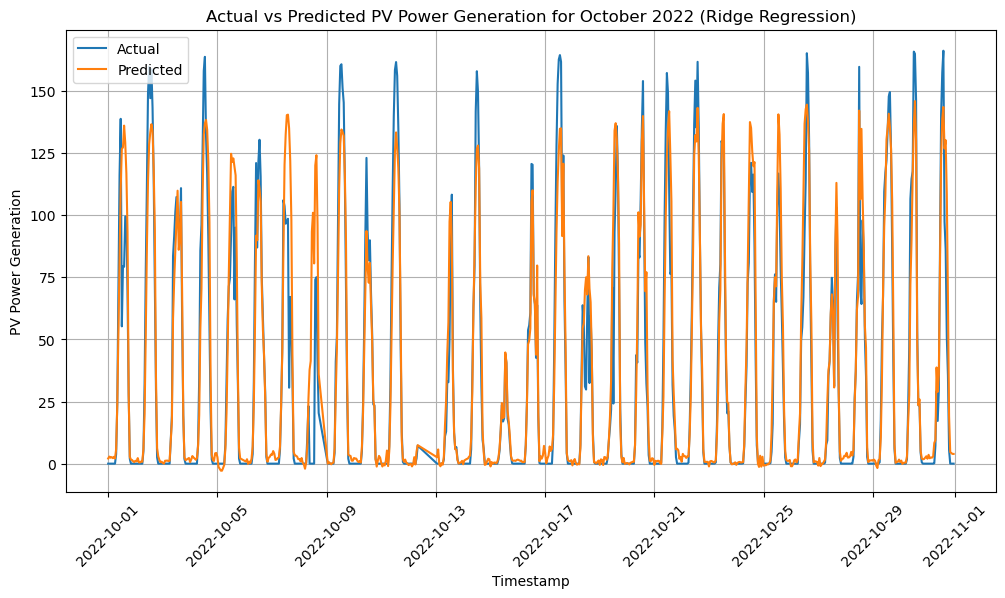

Metrics for October 2022 (Ridge Regression):
MAE: 8.581787259256949
MSE: 261.0929434766008
RMSE: 16.15837069374882
R-squared: 0.8889729010000431
MAPE: 6.141308160843963


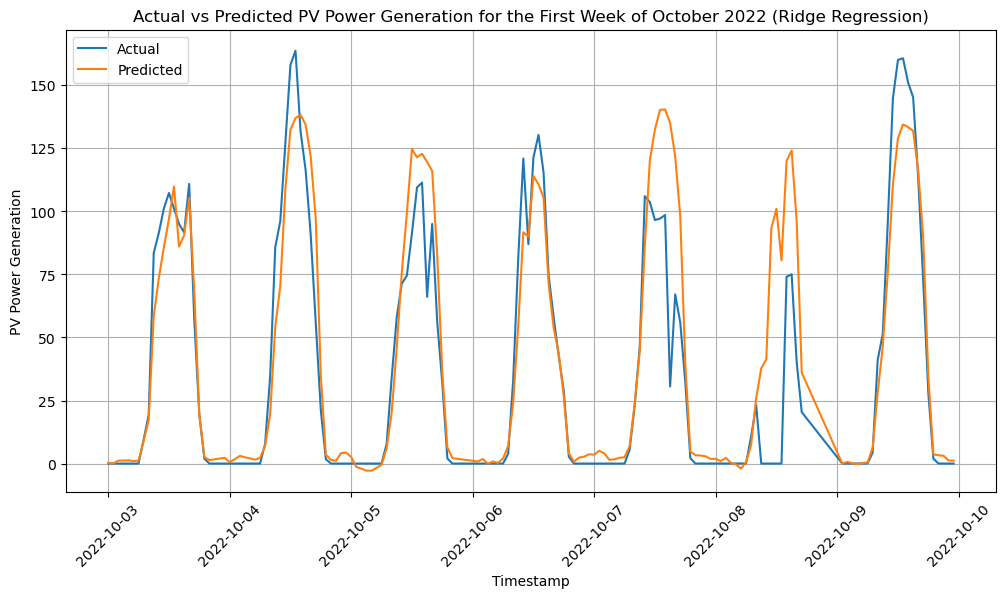

Metrics for the First Week of October 2022 (Ridge Regression):
MAE: 12.217199694628519
MSE: 505.7937752554313
RMSE: 22.489859387186733
R-squared: 0.7841113778227062
MAPE: 13.263262009292351


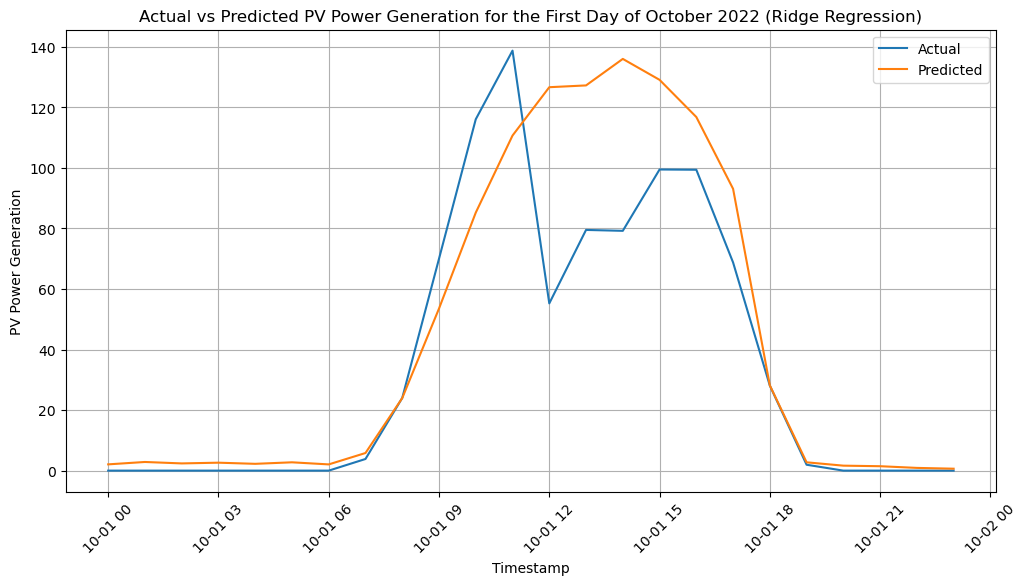

Metrics for the First Day of October 2022 (Ridge Regression):
MAE: 14.467500804072236
MSE: 601.8075161274968
RMSE: 24.53176545068652
R-squared: 0.6994106945446763
MAPE: 22.72016143988794


In [131]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read the CSV file with Pandas and parse the 'Timestamp' column as datetime
columns_to_include = list(range(10))
dataset = pd.read_csv('combined_data.csv', delimiter=';', usecols=columns_to_include, parse_dates=['Timestamp'])

# Ensure 'Timestamp' column is in the correct datetime format
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])



october_2022_data = dataset[(dataset['Timestamp'].dt.month == 10) & (dataset['Timestamp'].dt.year == 2022)]

X_october_2022 = october_2022_data.iloc[:, 1:-1].values  # Features
y_october_2022_actual = october_2022_data.iloc[:, -1].values  # Actual PV power generation

X_october_2022_poly = poly_features.transform(X_october_2022)
X_october_2022_poly_scaled = scaler.transform(X_october_2022_poly)
y_october_2022_pred_ridge = ridge_model.predict(X_october_2022_poly_scaled)

mae_october_2022 = mean_absolute_error(y_october_2022_actual, y_october_2022_pred_ridge)
mse_october_2022 = mean_squared_error(y_october_2022_actual, y_october_2022_pred_ridge)
rmse_october_2022 = np.sqrt(mse_october_2022)
r2_october_2022 = r2_score(y_october_2022_actual, y_october_2022_pred_ridge)

average_y_october_2022_actual = np.mean(y_october_2022_actual)
average_y_october_2022_pred_ridge = np.mean(y_october_2022_pred_ridge)
mape_october_2022 = np.abs((average_y_october_2022_actual - average_y_october_2022_pred_ridge) / average_y_october_2022_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(october_2022_data['Timestamp'], y_october_2022_actual, label='Actual')
plt.plot(october_2022_data['Timestamp'], y_october_2022_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for October 2022 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for October 2022 (Ridge Regression):")
print("MAE:", mae_october_2022)
print("MSE:", mse_october_2022)
print("RMSE:", rmse_october_2022)
print("R-squared:", r2_october_2022)
print("MAPE:", mape_october_2022)


first_week_october_data = dataset[(dataset['Timestamp'].dt.isocalendar().week == 40) & (dataset['Timestamp'].dt.year == 2022)]

X_first_week_october = first_week_october_data.iloc[:, 1:-1].values  # Features
y_first_week_october_actual = first_week_october_data.iloc[:, -1].values  # Actual PV power generation

X_first_week_october_poly = poly_features.transform(X_first_week_october)
X_first_week_october_poly_scaled = scaler.transform(X_first_week_october_poly)
y_first_week_october_pred_ridge = ridge_model.predict(X_first_week_october_poly_scaled)

mae_first_week_october = mean_absolute_error(y_first_week_october_actual, y_first_week_october_pred_ridge)
mse_first_week_october = mean_squared_error(y_first_week_october_actual, y_first_week_october_pred_ridge)
rmse_first_week_october = np.sqrt(mse_first_week_october)
r2_first_week_october = r2_score(y_first_week_october_actual, y_first_week_october_pred_ridge)

average_y_first_week_october_actual = np.mean(y_first_week_october_actual)
average_y_first_week_october_pred_ridge = np.mean(y_first_week_october_pred_ridge)
mape_first_week_october = np.abs((average_y_first_week_october_actual - average_y_first_week_october_pred_ridge) / average_y_first_week_october_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(first_week_october_data['Timestamp'], y_first_week_october_actual, label='Actual')
plt.plot(first_week_october_data['Timestamp'], y_first_week_october_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of October 2022 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for the First Week of October 2022 (Ridge Regression):")
print("MAE:", mae_first_week_october)
print("MSE:", mse_first_week_october)
print("RMSE:", rmse_first_week_october)
print("R-squared:", r2_first_week_october)
print("MAPE:", mape_first_week_october)


first_day_october_data = dataset[(dataset['Timestamp'].dt.day == 1) & (dataset['Timestamp'].dt.month == 10) & (dataset['Timestamp'].dt.year == 2022)]

X_first_day_october = first_day_october_data.iloc[:, 1:-1].values  # Features
y_first_day_october_actual = first_day_october_data.iloc[:, -1].values  # Actual PV power generation

X_first_day_october_poly = poly_features.transform(X_first_day_october)
X_first_day_october_poly_scaled = scaler.transform(X_first_day_october_poly)
y_first_day_october_pred_ridge = ridge_model.predict(X_first_day_october_poly_scaled)

mae_first_day_october = mean_absolute_error(y_first_day_october_actual, y_first_day_october_pred_ridge)
mse_first_day_october = mean_squared_error(y_first_day_october_actual, y_first_day_october_pred_ridge)
rmse_first_day_october = np.sqrt(mse_first_day_october)
r2_first_day_october = r2_score(y_first_day_october_actual, y_first_day_october_pred_ridge)

average_y_first_day_october_actual = np.mean(y_first_day_october_actual)
average_y_first_day_october_pred_ridge = np.mean(y_first_day_october_pred_ridge)
mape_first_day_october = np.abs((average_y_first_day_october_actual - average_y_first_day_october_pred_ridge) / average_y_first_day_october_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(first_day_october_data['Timestamp'], y_first_day_october_actual, label='Actual')
plt.plot(first_day_october_data['Timestamp'], y_first_day_october_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Day of October 2022 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for the First Day of October 2022 (Ridge Regression):")
print("MAE:", mae_first_day_october)
print("MSE:", mse_first_day_october)
print("RMSE:", rmse_first_day_october)
print("R-squared:", r2_first_day_october)
print("MAPE:", mape_first_day_october)


December 2022

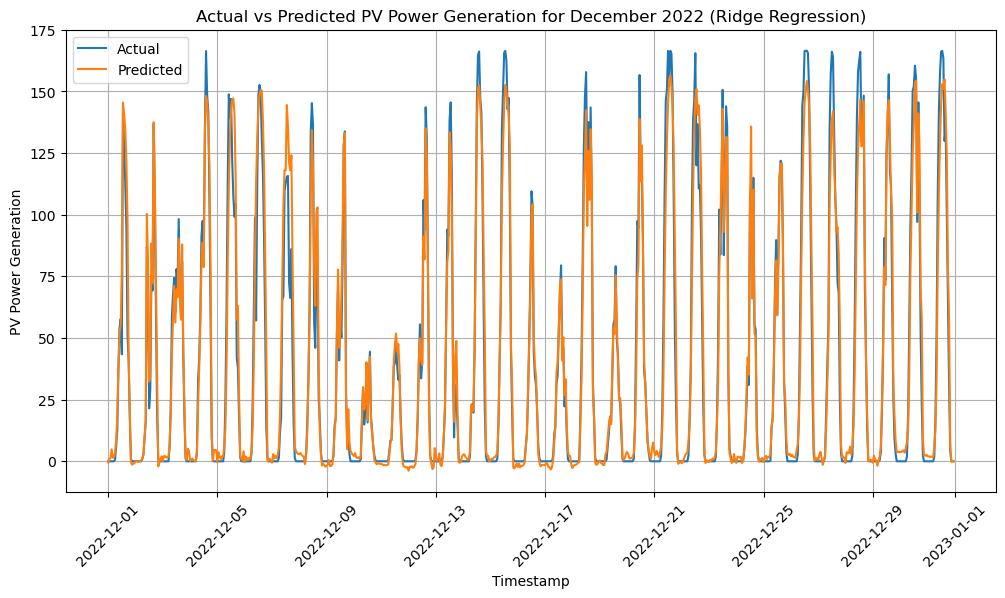

Metrics for December 2022 (Ridge Regression):
MAE: 6.706661787879861
MSE: 129.0247539958594
RMSE: 11.35890637323239
R-squared: 0.9530062052570033
MAPE: 1.2499178863754827


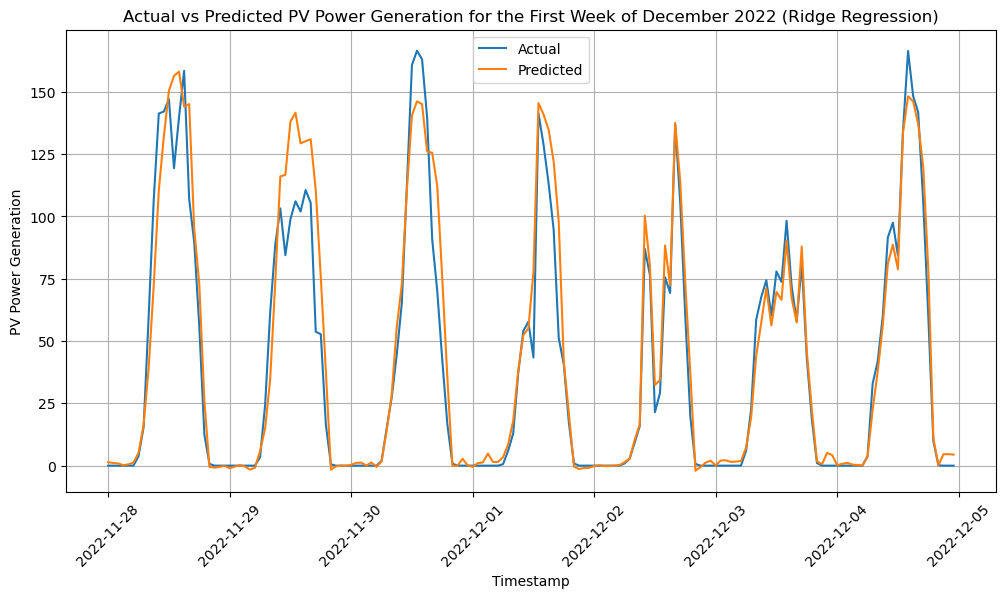

Metrics for the First Week of December 2022 (Ridge Regression):
MAE: 7.9623697599950125
MSE: 187.48804674899105
RMSE: 13.692627459658393
R-squared: 0.9251215258429197
MAPE: 7.933907753298117


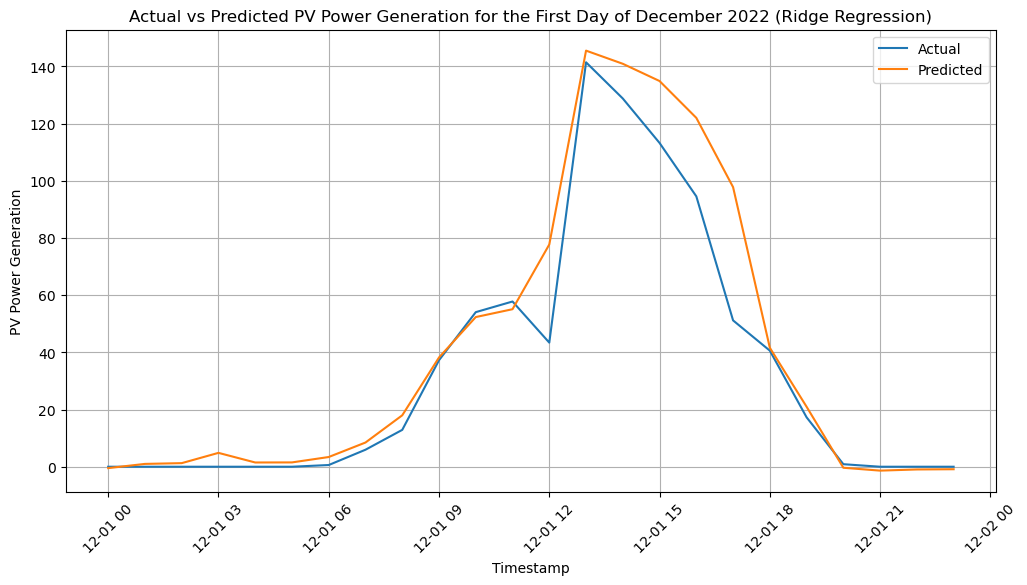

Metrics for the First Day of December 2022 (Ridge Regression):
MAE: 7.57082413275203
MSE: 201.50023611294128
RMSE: 14.195077883299595
R-squared: 0.8948080300823467
MAPE: 20.389154395079682


In [132]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read the CSV file with Pandas and parse the 'Timestamp' column as datetime
columns_to_include = list(range(10))
dataset = pd.read_csv('combined_data.csv', delimiter=';', usecols=columns_to_include, parse_dates=['Timestamp'])

# Ensure 'Timestamp' column is in the correct datetime format
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])




december_2022_data = dataset[(dataset['Timestamp'].dt.month == 12) & (dataset['Timestamp'].dt.year == 2022)]

X_december_2022 = december_2022_data.iloc[:, 1:-1].values  # Features
y_december_2022_actual = december_2022_data.iloc[:, -1].values  # Actual PV power generation

X_december_2022_poly = poly_features.transform(X_december_2022)
X_december_2022_poly_scaled = scaler.transform(X_december_2022_poly)
y_december_2022_pred_ridge = ridge_model.predict(X_december_2022_poly_scaled)

mae_december_2022 = mean_absolute_error(y_december_2022_actual, y_december_2022_pred_ridge)
mse_december_2022 = mean_squared_error(y_december_2022_actual, y_december_2022_pred_ridge)
rmse_december_2022 = np.sqrt(mse_december_2022)
r2_december_2022 = r2_score(y_december_2022_actual, y_december_2022_pred_ridge)

average_y_december_2022_actual = np.mean(y_december_2022_actual)
average_y_december_2022_pred_ridge = np.mean(y_december_2022_pred_ridge)
mape_december_2022 = np.abs((average_y_december_2022_actual - average_y_december_2022_pred_ridge) / average_y_december_2022_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(december_2022_data['Timestamp'], y_december_2022_actual, label='Actual')
plt.plot(december_2022_data['Timestamp'], y_december_2022_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for December 2022 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for December 2022 (Ridge Regression):")
print("MAE:", mae_december_2022)
print("MSE:", mse_december_2022)
print("RMSE:", rmse_december_2022)
print("R-squared:", r2_december_2022)
print("MAPE:", mape_december_2022)


first_week_december_data = dataset[(dataset['Timestamp'].dt.isocalendar().week == 48) & (dataset['Timestamp'].dt.year == 2022)]

X_first_week_december = first_week_december_data.iloc[:, 1:-1].values  # Features
y_first_week_december_actual = first_week_december_data.iloc[:, -1].values  # Actual PV power generation

X_first_week_december_poly = poly_features.transform(X_first_week_december)
X_first_week_december_poly_scaled = scaler.transform(X_first_week_december_poly)
y_first_week_december_pred_ridge = ridge_model.predict(X_first_week_december_poly_scaled)

mae_first_week_december = mean_absolute_error(y_first_week_december_actual, y_first_week_december_pred_ridge)
mse_first_week_december = mean_squared_error(y_first_week_december_actual, y_first_week_december_pred_ridge)
rmse_first_week_december = np.sqrt(mse_first_week_december)
r2_first_week_december = r2_score(y_first_week_december_actual, y_first_week_december_pred_ridge)

average_y_first_week_december_actual = np.mean(y_first_week_december_actual)
average_y_first_week_december_pred_ridge = np.mean(y_first_week_december_pred_ridge)
mape_first_week_december = np.abs((average_y_first_week_december_actual - average_y_first_week_december_pred_ridge) / average_y_first_week_december_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(first_week_december_data['Timestamp'], y_first_week_december_actual, label='Actual')
plt.plot(first_week_december_data['Timestamp'], y_first_week_december_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of December 2022 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for the First Week of December 2022 (Ridge Regression):")
print("MAE:", mae_first_week_december)
print("MSE:", mse_first_week_december)
print("RMSE:", rmse_first_week_december)
print("R-squared:", r2_first_week_december)
print("MAPE:", mape_first_week_december)


first_day_december_data = dataset[(dataset['Timestamp'].dt.day == 1) & (dataset['Timestamp'].dt.month == 12) & (dataset['Timestamp'].dt.year == 2022)]

X_first_day_december = first_day_december_data.iloc[:, 1:-1].values  # Features
y_first_day_december_actual = first_day_december_data.iloc[:, -1].values  # Actual PV power generation

X_first_day_december_poly = poly_features.transform(X_first_day_december)
X_first_day_december_poly_scaled = scaler.transform(X_first_day_december_poly)
y_first_day_december_pred_ridge = ridge_model.predict(X_first_day_december_poly_scaled)

mae_first_day_december = mean_absolute_error(y_first_day_december_actual, y_first_day_december_pred_ridge)
mse_first_day_december = mean_squared_error(y_first_day_december_actual, y_first_day_december_pred_ridge)
rmse_first_day_december = np.sqrt(mse_first_day_december)
r2_first_day_december = r2_score(y_first_day_december_actual, y_first_day_december_pred_ridge)

average_y_first_day_december_actual = np.mean(y_first_day_december_actual)
average_y_first_day_december_pred_ridge = np.mean(y_first_day_december_pred_ridge)
mape_first_day_december = np.abs((average_y_first_day_december_actual - average_y_first_day_december_pred_ridge) / average_y_first_day_december_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(first_day_december_data['Timestamp'], y_first_day_december_actual, label='Actual')
plt.plot(first_day_december_data['Timestamp'], y_first_day_december_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Day of December 2022 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for the First Day of December 2022 (Ridge Regression):")
print("MAE:", mae_first_day_december)
print("MSE:", mse_first_day_december)
print("RMSE:", rmse_first_day_december)
print("R-squared:", r2_first_day_december)
print("MAPE:", mape_first_day_december)


March 2023

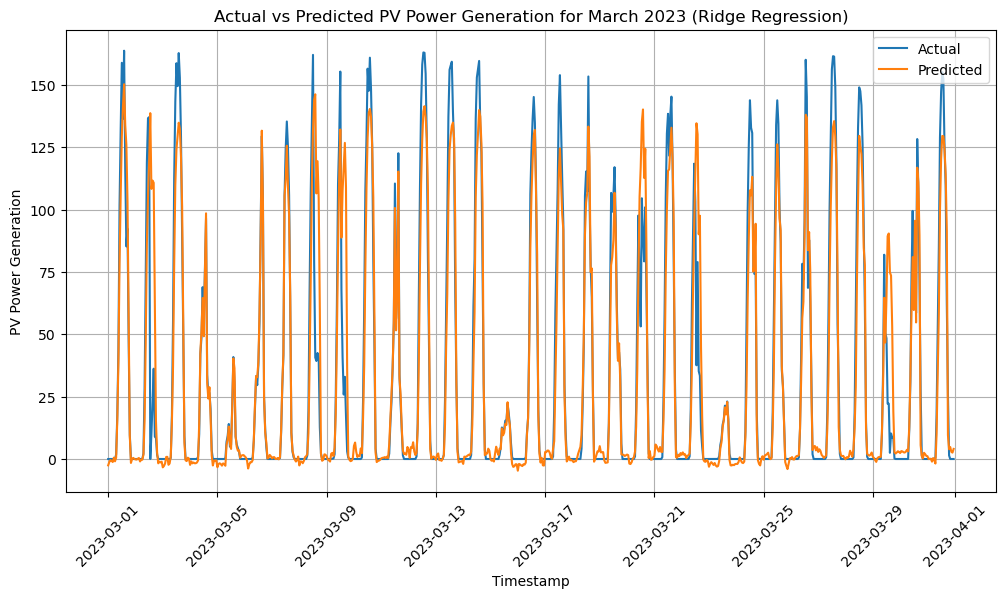

Metrics for March 2023 (Ridge Regression):
MAE: 8.91926135520559
MSE: 331.82349250952814
RMSE: 18.216022960831165
R-squared: 0.8651332202035519
MAPE: 1.4095703752625575


Metrics for the First Week of March 2023 (Ridge Regression):
MAE: 8.313751384913143
MSE: 377.21980361137486
RMSE: 19.4221472451265
R-squared: 0.8525613458707907
MAPE: 1.5266803188296283


Metrics for the First Day of March 2023 (Ridge Regression):
MAE: 7.9695973275846255
MSE: 185.72344913582901
RMSE: 13.628039078892789
R-squared: 0.9451098110458045
MAPE: 2.469730341824899


In [133]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read the CSV file with Pandas and parse the 'Timestamp' column as datetime
columns_to_include = list(range(10))
dataset = pd.read_csv('combined_data.csv', delimiter=';', usecols=columns_to_include, parse_dates=['Timestamp'])

# Ensure 'Timestamp' column is in the correct datetime format
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])

march_2023_data = dataset[(dataset['Timestamp'].dt.month == 3) & (dataset['Timestamp'].dt.year == 2023)]

X_march_2023 = march_2023_data.iloc[:, 1:-1].values  # Features
y_march_2023_actual = march_2023_data.iloc[:, -1].values  # Actual PV power generation

X_march_2023_poly = poly_features.transform(X_march_2023)
X_march_2023_poly_scaled = scaler.transform(X_march_2023_poly)
y_march_2023_pred_ridge = ridge_model.predict(X_march_2023_poly_scaled)

mae_march_2023 = mean_absolute_error(y_march_2023_actual, y_march_2023_pred_ridge)
mse_march_2023 = mean_squared_error(y_march_2023_actual, y_march_2023_pred_ridge)
rmse_march_2023 = np.sqrt(mse_march_2023)
r2_march_2023 = r2_score(y_march_2023_actual, y_march_2023_pred_ridge)

average_y_march_2023_actual = np.mean(y_march_2023_actual)
average_y_march_2023_pred_ridge = np.mean(y_march_2023_pred_ridge)
mape_march_2023 = np.abs((average_y_march_2023_actual - average_y_march_2023_pred_ridge) / average_y_march_2023_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(march_2023_data['Timestamp'], y_march_2023_actual, label='Actual')
plt.plot(march_2023_data['Timestamp'], y_march_2023_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for March 2023 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for March 2023 (Ridge Regression):")
print("MAE:", mae_march_2023)
print("MSE:", mse_march_2023)
print("RMSE:", rmse_march_2023)
print("R-squared:", r2_march_2023)
print("MAPE:", mape_march_2023)

first_week_march_data = dataset[(dataset['Timestamp'].dt.isocalendar().week == 9) & (dataset['Timestamp'].dt.year == 2023)]

X_first_week_march = first_week_march_data.iloc[:, 1:-1].values  # Features
y_first_week_march_actual = first_week_march_data.iloc[:, -1].values  # Actual PV power generation


X_first_week_march_poly = poly_features.transform(X_first_week_march)
X_first_week_march_poly_scaled = scaler.transform(X_first_week_march_poly)
y_first_week_march_pred_ridge = ridge_model.predict(X_first_week_march_poly_scaled)


mae_first_week_march = mean_absolute_error(y_first_week_march_actual, y_first_week_march_pred_ridge)
mse_first_week_march = mean_squared_error(y_first_week_march_actual, y_first_week_march_pred_ridge)
rmse_first_week_march = np.sqrt(mse_first_week_march)
r2_first_week_march = r2_score(y_first_week_march_actual, y_first_week_march_pred_ridge)

average_y_first_week_march_actual = np.mean(y_first_week_march_actual)
average_y_first_week_march_pred_ridge = np.mean(y_first_week_march_pred_ridge)
mape_first_week_march = np.abs((average_y_first_week_march_actual - average_y_first_week_march_pred_ridge) / average_y_first_week_march_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(first_week_march_data['Timestamp'], y_first_week_march_actual, label='Actual')
plt.plot(first_week_march_data['Timestamp'], y_first_week_march_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Week of March 2023 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for the First Week of March 2023 (Ridge Regression):")
print("MAE:", mae_first_week_march)
print("MSE:", mse_first_week_march)
print("RMSE:", rmse_first_week_march)
print("R-squared:", r2_first_week_march)
print("MAPE:", mape_first_week_march)

first_day_march_data = dataset[(dataset['Timestamp'].dt.day == 1) & (dataset['Timestamp'].dt.month == 3) & (dataset['Timestamp'].dt.year == 2023)]

X_first_day_march = first_day_march_data.iloc[:, 1:-1].values  # Features
y_first_day_march_actual = first_day_march_data.iloc[:, -1].values  # Actual PV power generation

X_first_day_march_poly = poly_features.transform(X_first_day_march)
X_first_day_march_poly_scaled = scaler.transform(X_first_day_march_poly)
y_first_day_march_pred_ridge = ridge_model.predict(X_first_day_march_poly_scaled)

mae_first_day_march = mean_absolute_error(y_first_day_march_actual, y_first_day_march_pred_ridge)
mse_first_day_march = mean_squared_error(y_first_day_march_actual, y_first_day_march_pred_ridge)
rmse_first_day_march = np.sqrt(mse_first_day_march)
r2_first_day_march = r2_score(y_first_day_march_actual, y_first_day_march_pred_ridge)

average_y_first_day_march_actual = np.mean(y_first_day_march_actual)
average_y_first_day_march_pred_ridge = np.mean(y_first_day_march_pred_ridge)
mape_first_day_march = np.abs((average_y_first_day_march_actual - average_y_first_day_march_pred_ridge) / average_y_first_day_march_actual) * 100

plt.figure(figsize=(12, 6))
plt.plot(first_day_march_data['Timestamp'], y_first_day_march_actual, label='Actual')
plt.plot(first_day_march_data['Timestamp'], y_first_day_march_pred_ridge, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for the First Day of March 2023 (Ridge Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Metrics for the First Day of March 2023 (Ridge Regression):")
print("MAE:", mae_first_day_march)
print("MSE:", mse_first_day_march)
print("RMSE:", rmse_first_day_march)
print("R-squared:", r2_first_day_march)
print("MAPE:", mape_first_day_march)


# CROSS-MAKING MLR GRAPHS

First one is from looking at ALL results.xlsx and chose 1 march 2023 as chosen day.

In [208]:
import matplotlib.pyplot as plt

# Data for the first day of March 2023 for each technique
timestamps = march_1st_2023_data['Timestamp']
actual_values = y_march_1st_2023_actual
predicted_values_feature_selection = y_march_1st_2023_pred_selected
predicted_values_polynomial = y_march_1st_2023_pred_poly
predicted_values_ridge = y_first_day_march_pred_ridge

# Plotting
plt.figure(figsize=(8, 4))

plt.plot(timestamps, actual_values, label='Actual', )
plt.plot(timestamps, predicted_values_feature_selection, label='Feature Selection', )
plt.plot(timestamps, predicted_values_polynomial, label='Polynomial Regression', )
plt.plot(timestamps, predicted_values_ridge, label='Ridge Regression', )

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('Actual vs Predicted PV Power Generation for 1st March 2023')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now 1 decmeber as chosen day

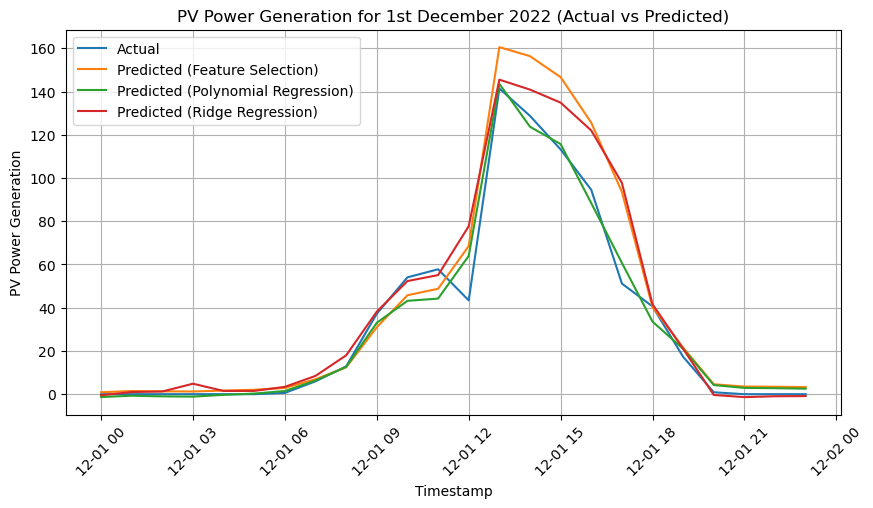

In [204]:
# Plotting for the first day of December 2022 for all three techniques
plt.figure(figsize=(10, 5))

# Actual values
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_actual, label='Actual')

# Feature Selection
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_pred_selected, label='Predicted (Feature Selection)')

# Polynomial Regression
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_pred_poly, label='Predicted (Polynomial Regression)')

# Ridge Regression
plt.plot(first_day_december_data['Timestamp'], y_first_day_december_pred_ridge, label='Predicted (Ridge Regression)')

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('PV Power Generation for 1st December 2022 (Actual vs Predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


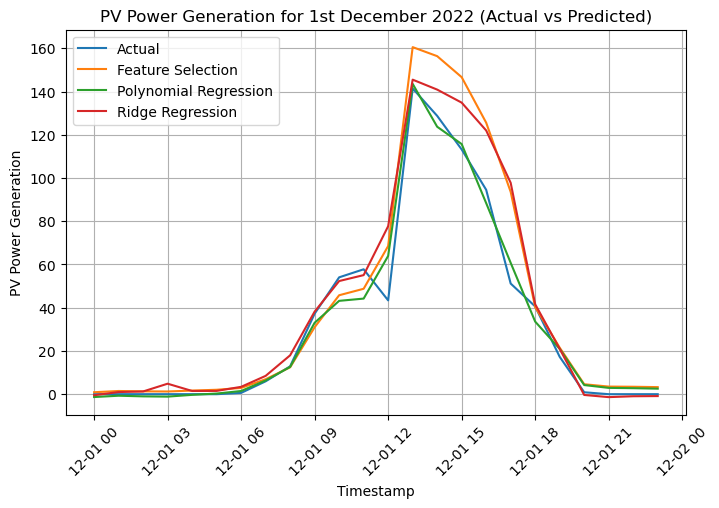

In [198]:
# Plotting for the first day of December 2022 for all three techniques
plt.figure(figsize=(8, 5))

# Actual values
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_actual, label='Actual')

# Feature Selection
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_pred_selected, label='Feature Selection')

# Polynomial Regression
plt.plot(december_1st_2022_data['Timestamp'], y_december_1st_2022_pred_poly, label='Polynomial Regression')

# Ridge Regression
plt.plot(first_day_december_data['Timestamp'], y_first_day_december_pred_ridge, label='Ridge Regression')

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('PV Power Generation for 1st December 2022 (Actual vs Predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


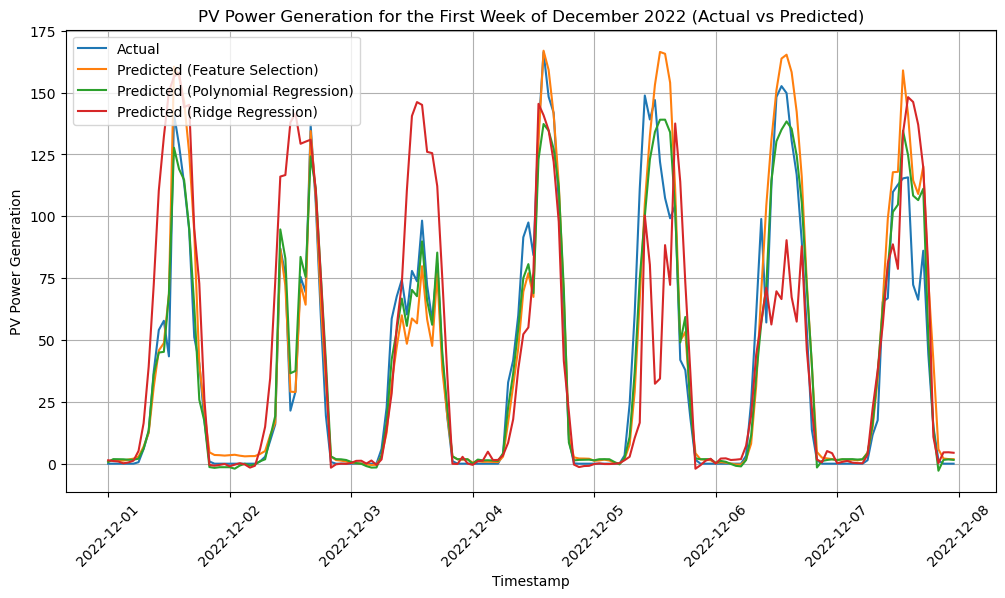

In [176]:
# Plotting for the first week of December 2022 for all three techniques
plt.figure(figsize=(12, 6))

# Actual values
plt.plot(first_week_december_2022_data['Timestamp'], y_first_week_december_2022_actual, label='Actual')

# Feature Selection
plt.plot(first_week_december_2022_data['Timestamp'], y_first_week_december_2022_pred_selected, label='Predicted (Feature Selection)')

# Polynomial Regression
plt.plot(first_week_december_2022_data['Timestamp'], y_first_week_december_2022_pred_poly, label='Predicted (Polynomial Regression)')

# Ridge Regression
plt.plot(first_week_december_2022_data['Timestamp'], y_first_week_december_pred_ridge, label='Predicted (Ridge Regression)')

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('PV Power Generation for the First Week of December 2022 (Actual vs Predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


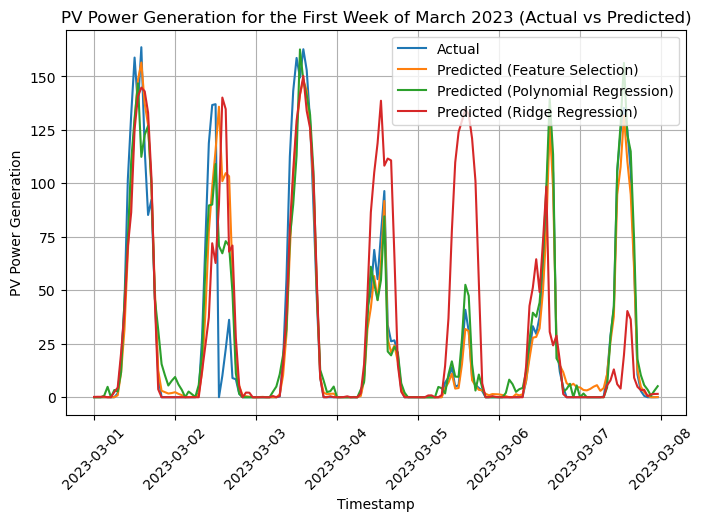

In [182]:
import numpy as np
import matplotlib.pyplot as plt

y_first_week_march_2023_pred_selected_non_negative = np.maximum(y_first_week_march_2023_pred_selected, 0)
y_first_week_march_2023_pred_poly_non_negative = np.maximum(y_first_week_march_2023_pred_poly, 0)
y_first_week_march_pred_ridge_non_negative = np.maximum(y_first_week_march_pred_ridge, 0)

plt.figure(figsize=(8, 5))

plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_actual, label='Actual')

plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_pred_selected_non_negative, label='Predicted (Feature Selection)')

plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_pred_poly_non_negative, label='Predicted (Polynomial Regression)')

plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_pred_ridge_non_negative, label='Predicted (Ridge Regression)')

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('PV Power Generation for the First Week of March 2023 (Actual vs Predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


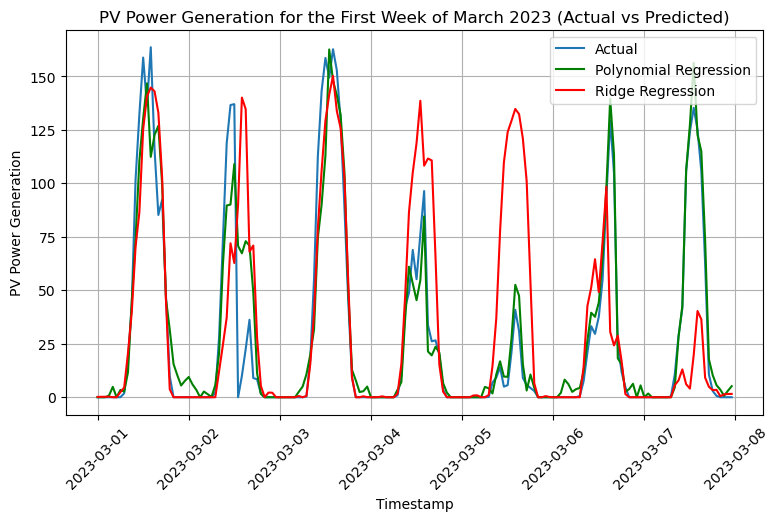

In [200]:
import numpy as np
import matplotlib.pyplot as plt


y_first_week_march_2023_pred_selected_non_negative = np.maximum(y_first_week_march_2023_pred_selected, 0)
y_first_week_march_2023_pred_poly_non_negative = np.maximum(y_first_week_march_2023_pred_poly, 0)
y_first_week_march_pred_ridge_non_negative = np.maximum(y_first_week_march_pred_ridge, 0)


plt.figure(figsize=(9, 5))


plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_actual, label='Actual')


plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_2023_pred_poly_non_negative, label='Polynomial Regression', color='green')


plt.plot(first_week_march_2023_data['Timestamp'], y_first_week_march_pred_ridge_non_negative, label='Ridge Regression', color='red')

plt.xlabel('Timestamp')
plt.ylabel('PV Power Generation')
plt.title('PV Power Generation for the First Week of March 2023 (Actual vs Predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def rmse_scorer(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse


october_scores = cross_val_score(model, X_october, y_october_actual, cv=10, scoring=make_scorer(rmse_scorer))
october_mean_rmse = np.mean(october_scores)
print("Mean RMSE from Cross-Validation for October 2022:", october_mean_rmse)


december_scores = cross_val_score(model, X_december, y_december_actual, cv=10, scoring=make_scorer(rmse_scorer))
december_mean_rmse = np.mean(december_scores)
print("Mean RMSE from Cross-Validation for December 2022:", december_mean_rmse)


march_scores = cross_val_score(model, X_march, y_march_actual, cv=10, scoring=make_scorer(rmse_scorer))
march_mean_rmse = np.mean(march_scores)
print("Mean RMSE from Cross-Validation for March 2023:", march_mean_rmse)


Mean RMSE from Cross-Validation for October 2022: 16.15351161057219
Mean RMSE from Cross-Validation for December 2022: 12.433650514696987
Mean RMSE from Cross-Validation for March 2023: 17.59176038259689


TRYING FEATURE ENGINEERING

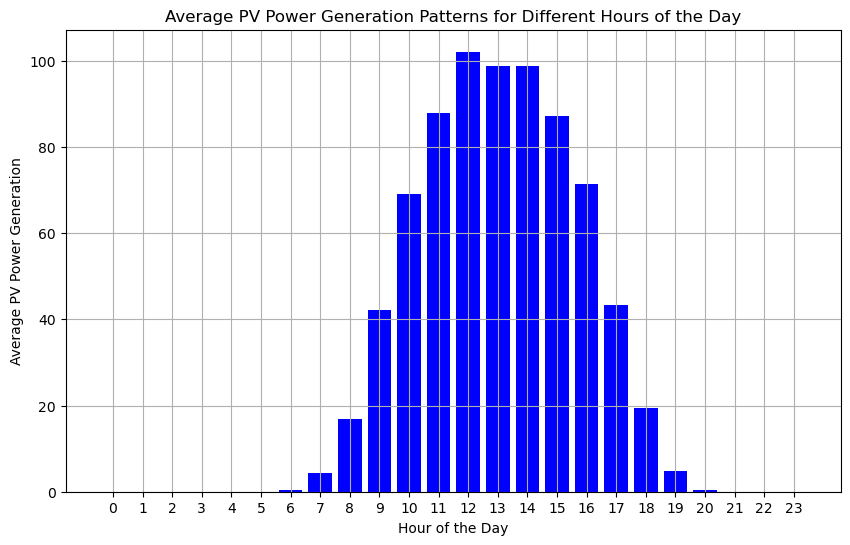

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('combined_data.csv', delimiter=';')

data['Timestamp'] = pd.to_datetime(data['Timestamp'])

data['Hour'] = data['Timestamp'].dt.hour

start_date = '2022-09-10'
end_date = '2023-09-10'
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)]
hourly_avg_generation = filtered_data.groupby('Hour')['PV yield counter'].mean()

plt.figure(figsize=(10, 6))
plt.bar(hourly_avg_generation.index, hourly_avg_generation.values, color='b')
plt.xlabel('Hour of the Day')
plt.ylabel('Average PV Power Generation')
plt.title('Average PV Power Generation Patterns for Different Hours of the Day')
plt.xticks(hourly_avg_generation.index)
plt.grid(True)
plt.show()
